In [249]:
from typing import Tuple, Optional, Union
import math
import torch as th
import torch
import torch.nn as nn
import torchaudio as ta
from torchaudio.transforms import PSD
import torch.nn.functional as F

from Modules import STFT, MVDR
from model import Unet_model
from data import my_dataset
from matplotlib import pyplot as plt
from loss import MultiResSpecLoss

In [250]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from model import DownSample, UpSample

class Unet_model(nn.Module):
    def __init__(
        self, input_channel=1, out_channel=32, complex_input=True, log_flag=True, subband_flag=False):
        super().__init__()
        self.complex_input = complex_input
        self.log_flag = log_flag
        self.subband_flag = subband_flag
        
        self.down_1 = DownSample(
                input_channel=40,
                out_channel=64, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(64)
            )
        
        self.down_2 = DownSample(
                input_channel=64,
                out_channel=128, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(128)
            )
        
        self.lstm = nn.LSTM(input_size=256, 
                            hidden_size=256, 
                            num_layers=1, 
                            batch_first=True)
        
        
        self.up_1 = UpSample(
            input_channel=128+128, 
            out_channel=64, 
            kernel_size=(6, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(64)
        )    
        

        self.up_2 = UpSample(
            input_channel=64+64, 
            out_channel=32, 
            kernel_size=(4, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(32)
        )   
        
        
        self.fc = nn.Sequential(
            nn.Linear(40*32, 200),
            #nn.Sigmoid()
        )
    
    def cac2cws(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c,k,f//k,t)
        x = x.reshape(b,c*k,f//k,t)
        return x
    
    def cws2cac(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c//k,k,f,t)
        x = x.reshape(b,c//k,f*k,t)
        return x
    
    def forward(self, x):
        B, C, F, T = x.shape
        
        if self.complex_input:
            x = torch.concat([x.real, x.imag], dim=1)
        elif self.log_flag:
            x = torch.log(x + 1e-5)
        
        if self.subband_flag:
            x = self.cac2cws(x)
        
        x1 = self.down_1(x)
        x2 = self.down_2(x1)        
        _, C_c, F_c, _ = x2.shape
        x = x2.view(B, -1, T).permute(0, 2, 1) # (B, C, F, T) -> (B, C*F, T) -> (B, T, C*F)
        
        x = self.lstm(x)[0] + x
        
        x = x.permute(0, 2, 1).view(B, C_c, F_c, T)
        x = self.up_1(torch.concat([x, x2],dim=1))
        x = self.up_2(torch.concat([x, x1],dim=1))
        
        x = x.view(B, -1, T).permute(0, 2, 1)
        x = self.fc(x)
        
        return x.view(B, 1, F, T)

In [256]:
data_train = my_dataset('./beam_data/train')

model_mask = Unet_model(subband_flag=True)
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [257]:
train_target, train_sample, train_noise = data_train[0]

In [258]:
crit = MultiResSpecLoss(factor=100,
            f_complex=100,
            gamma=0.3,
            n_ffts=[1024, window_length])

In [260]:
from tqdm import tqdm
from torchmetrics import ScaleInvariantSignalNoiseRatio

epochs = 1000

optim = torch.optim.AdamW(model_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )

si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
#     mvdr = MVDR(0)
    spec_sample = stft.stft(train_sample[None])
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

    mask = model_mask(spec_sample)
#     z = mvdr(spec_sample, mask[0])
    mag_predict = mag * mask

    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = crit(wave_predict, train_target[None]) + F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target[None]))
    losses.append(loss.item())
    print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

  0%|▏                                                                                | 2/1000 [00:00<03:20,  4.99it/s]

Epoch [1/1000], loss: 6.3273, metric: -12.3507
Epoch [2/1000], loss: 5.7874, metric: -8.0463


  0%|▎                                                                                | 4/1000 [00:00<03:22,  4.92it/s]

Epoch [3/1000], loss: 5.3804, metric: -5.7931
Epoch [4/1000], loss: 5.0653, metric: -4.6475


  1%|▍                                                                                | 6/1000 [00:01<03:20,  4.97it/s]

Epoch [5/1000], loss: 4.8068, metric: -3.8080
Epoch [6/1000], loss: 4.5815, metric: -3.1132


  1%|▋                                                                                | 8/1000 [00:01<03:25,  4.84it/s]

Epoch [7/1000], loss: 4.3855, metric: -2.5379
Epoch [8/1000], loss: 4.2168, metric: -2.0184


  1%|▋                                                                                | 9/1000 [00:01<03:24,  4.84it/s]

Epoch [9/1000], loss: 4.0667, metric: -1.5445


  1%|▊                                                                               | 10/1000 [00:02<03:27,  4.77it/s]

Epoch [10/1000], loss: 3.9296, metric: -1.1033


  1%|▉                                                                               | 11/1000 [00:02<03:32,  4.66it/s]

Epoch [11/1000], loss: 3.8050, metric: -0.7207


  1%|▉                                                                               | 12/1000 [00:02<03:29,  4.71it/s]

Epoch [12/1000], loss: 3.6935, metric: -0.4193


  1%|█                                                                               | 14/1000 [00:02<03:30,  4.68it/s]

Epoch [13/1000], loss: 3.5901, metric: -0.1742
Epoch [14/1000], loss: 3.4945, metric: 0.0472


  2%|█▎                                                                              | 16/1000 [00:03<03:31,  4.65it/s]

Epoch [15/1000], loss: 3.4053, metric: 0.2511
Epoch [16/1000], loss: 3.3214, metric: 0.4459


  2%|█▍                                                                              | 18/1000 [00:03<03:26,  4.76it/s]

Epoch [17/1000], loss: 3.2417, metric: 0.6360
Epoch [18/1000], loss: 3.1683, metric: 0.7953


  2%|█▌                                                                              | 20/1000 [00:04<03:26,  4.75it/s]

Epoch [19/1000], loss: 3.0985, metric: 0.9349
Epoch [20/1000], loss: 3.0305, metric: 1.0706


  2%|█▊                                                                              | 22/1000 [00:04<03:28,  4.70it/s]

Epoch [21/1000], loss: 2.9655, metric: 1.1995
Epoch [22/1000], loss: 2.9050, metric: 1.2986


  2%|█▊                                                                              | 23/1000 [00:04<03:29,  4.66it/s]

Epoch [23/1000], loss: 2.8473, metric: 1.4081
Epoch [24/1000], loss: 2.7923, metric: 1.5467


  2%|██                                                                              | 25/1000 [00:05<03:25,  4.75it/s]

Epoch [25/1000], loss: 2.7386, metric: 1.6925


  3%|██▏                                                                             | 27/1000 [00:05<03:22,  4.82it/s]

Epoch [26/1000], loss: 2.6862, metric: 1.8211
Epoch [27/1000], loss: 2.6366, metric: 1.9259


  3%|██▎                                                                             | 29/1000 [00:06<03:21,  4.83it/s]

Epoch [28/1000], loss: 2.5904, metric: 2.0187
Epoch [29/1000], loss: 2.5429, metric: 2.1151


  3%|██▍                                                                             | 31/1000 [00:06<03:15,  4.96it/s]

Epoch [30/1000], loss: 2.5087, metric: 2.1830
Epoch [31/1000], loss: 2.4742, metric: 2.2584


  3%|██▋                                                                             | 33/1000 [00:06<03:13,  4.99it/s]

Epoch [32/1000], loss: 2.4330, metric: 2.3409
Epoch [33/1000], loss: 2.3953, metric: 2.4058


  4%|██▊                                                                             | 35/1000 [00:07<03:14,  4.97it/s]

Epoch [34/1000], loss: 2.3584, metric: 2.4685
Epoch [35/1000], loss: 2.3213, metric: 2.5375


  4%|██▉                                                                             | 37/1000 [00:07<03:16,  4.90it/s]

Epoch [36/1000], loss: 2.2870, metric: 2.6041
Epoch [37/1000], loss: 2.2532, metric: 2.6831


  4%|███                                                                             | 39/1000 [00:08<03:14,  4.95it/s]

Epoch [38/1000], loss: 2.2199, metric: 2.7631
Epoch [39/1000], loss: 2.1893, metric: 2.8302


  4%|███▎                                                                            | 41/1000 [00:08<03:17,  4.86it/s]

Epoch [40/1000], loss: 2.1665, metric: 2.8568
Epoch [41/1000], loss: 2.1351, metric: 2.9090


  4%|███▎                                                                            | 42/1000 [00:08<03:14,  4.93it/s]

Epoch [42/1000], loss: 2.1055, metric: 2.9685


  4%|███▌                                                                            | 44/1000 [00:09<03:16,  4.87it/s]

Epoch [43/1000], loss: 2.0783, metric: 3.0277
Epoch [44/1000], loss: 2.0527, metric: 3.0770


  4%|███▌                                                                            | 45/1000 [00:09<03:15,  4.88it/s]

Epoch [45/1000], loss: 2.0264, metric: 3.1309


  5%|███▊                                                                            | 47/1000 [00:09<03:17,  4.81it/s]

Epoch [46/1000], loss: 2.0050, metric: 3.1696
Epoch [47/1000], loss: 1.9833, metric: 3.1949


  5%|███▉                                                                            | 49/1000 [00:10<03:16,  4.84it/s]

Epoch [48/1000], loss: 1.9602, metric: 3.2234
Epoch [49/1000], loss: 1.9375, metric: 3.2609


  5%|████                                                                            | 51/1000 [00:10<03:16,  4.83it/s]

Epoch [50/1000], loss: 1.9150, metric: 3.3062
Epoch [51/1000], loss: 1.8935, metric: 3.3438


  5%|████▏                                                                           | 53/1000 [00:10<03:11,  4.94it/s]

Epoch [52/1000], loss: 1.8764, metric: 3.3505
Epoch [53/1000], loss: 1.8562, metric: 3.3982


  6%|████▍                                                                           | 55/1000 [00:11<03:15,  4.84it/s]

Epoch [54/1000], loss: 1.8385, metric: 3.4591
Epoch [55/1000], loss: 1.8185, metric: 3.5144


  6%|████▍                                                                           | 56/1000 [00:11<03:12,  4.90it/s]

Epoch [56/1000], loss: 1.7994, metric: 3.5663
Epoch [57/1000], loss: 1.7819, metric: 3.5892


  6%|████▋                                                                           | 58/1000 [00:12<03:17,  4.76it/s]

Epoch [58/1000], loss: 1.7640, metric: 3.6243


  6%|████▊                                                                           | 60/1000 [00:12<03:17,  4.77it/s]

Epoch [59/1000], loss: 1.7463, metric: 3.6716
Epoch [60/1000], loss: 1.7294, metric: 3.7271


  6%|████▉                                                                           | 61/1000 [00:12<03:23,  4.61it/s]

Epoch [61/1000], loss: 1.7117, metric: 3.7665


  6%|████▉                                                                           | 62/1000 [00:12<03:29,  4.48it/s]

Epoch [62/1000], loss: 1.6960, metric: 3.7925


  6%|█████                                                                           | 64/1000 [00:13<03:28,  4.48it/s]

Epoch [63/1000], loss: 1.6803, metric: 3.8362
Epoch [64/1000], loss: 1.6681, metric: 3.8669


  6%|█████▏                                                                          | 65/1000 [00:13<03:23,  4.60it/s]

Epoch [65/1000], loss: 1.6661, metric: 3.8839


  7%|█████▎                                                                          | 66/1000 [00:13<03:29,  4.47it/s]

Epoch [66/1000], loss: 1.6646, metric: 3.8509


  7%|█████▍                                                                          | 68/1000 [00:14<03:23,  4.59it/s]

Epoch [67/1000], loss: 1.6319, metric: 3.9712
Epoch [68/1000], loss: 1.6218, metric: 3.9995


  7%|█████▌                                                                          | 69/1000 [00:14<03:20,  4.65it/s]

Epoch [69/1000], loss: 1.6110, metric: 4.0022


  7%|█████▌                                                                          | 70/1000 [00:14<03:21,  4.63it/s]

Epoch [70/1000], loss: 1.5930, metric: 4.0420


  7%|█████▋                                                                          | 71/1000 [00:14<03:22,  4.58it/s]

Epoch [71/1000], loss: 1.5851, metric: 4.0880


  7%|█████▊                                                                          | 72/1000 [00:15<03:24,  4.53it/s]

Epoch [72/1000], loss: 1.5662, metric: 4.1248


  7%|█████▊                                                                          | 73/1000 [00:15<03:27,  4.47it/s]

Epoch [73/1000], loss: 1.5588, metric: 4.1518


  7%|█████▉                                                                          | 74/1000 [00:15<03:26,  4.48it/s]

Epoch [74/1000], loss: 1.5428, metric: 4.2044
Epoch [75/1000], loss: 1.5324, metric: 4.2251


  8%|██████                                                                          | 76/1000 [00:16<03:22,  4.55it/s]

Epoch [76/1000], loss: 1.5195, metric: 4.2410
Epoch [77/1000], loss: 1.5085, metric: 4.2600


  8%|██████▎                                                                         | 79/1000 [00:16<03:10,  4.84it/s]

Epoch [78/1000], loss: 1.4952, metric: 4.2985
Epoch [79/1000], loss: 1.4846, metric: 4.3333


  8%|██████▍                                                                         | 80/1000 [00:16<03:09,  4.85it/s]

Epoch [80/1000], loss: 1.4768, metric: 4.3453


  8%|██████▍                                                                         | 81/1000 [00:17<03:20,  4.59it/s]

Epoch [81/1000], loss: 1.4665, metric: 4.3815


  8%|██████▌                                                                         | 82/1000 [00:17<03:24,  4.48it/s]

Epoch [82/1000], loss: 1.4573, metric: 4.4074


  8%|██████▋                                                                         | 84/1000 [00:17<03:20,  4.57it/s]

Epoch [83/1000], loss: 1.4512, metric: 4.4317
Epoch [84/1000], loss: 1.4377, metric: 4.4749


  9%|██████▉                                                                         | 86/1000 [00:18<03:15,  4.67it/s]

Epoch [85/1000], loss: 1.4246, metric: 4.5170
Epoch [86/1000], loss: 1.4128, metric: 4.5615


  9%|███████                                                                         | 88/1000 [00:18<03:14,  4.70it/s]

Epoch [87/1000], loss: 1.4067, metric: 4.5771
Epoch [88/1000], loss: 1.4034, metric: 4.5804


  9%|███████▏                                                                        | 90/1000 [00:18<03:04,  4.92it/s]

Epoch [89/1000], loss: 1.4013, metric: 4.5971
Epoch [90/1000], loss: 1.3859, metric: 4.6235


  9%|███████▎                                                                        | 91/1000 [00:19<03:07,  4.85it/s]

Epoch [91/1000], loss: 1.3778, metric: 4.6222


  9%|███████▍                                                                        | 93/1000 [00:19<03:05,  4.88it/s]

Epoch [92/1000], loss: 1.3754, metric: 4.6382
Epoch [93/1000], loss: 1.3590, metric: 4.7275


 10%|███████▌                                                                        | 95/1000 [00:19<03:02,  4.96it/s]

Epoch [94/1000], loss: 1.3568, metric: 4.7234
Epoch [95/1000], loss: 1.3542, metric: 4.7260


 10%|███████▋                                                                        | 96/1000 [00:20<03:03,  4.94it/s]

Epoch [96/1000], loss: 1.3449, metric: 4.7345


 10%|███████▊                                                                        | 97/1000 [00:20<03:04,  4.89it/s]

Epoch [97/1000], loss: 1.3411, metric: 4.7426


 10%|███████▉                                                                        | 99/1000 [00:20<03:05,  4.85it/s]

Epoch [98/1000], loss: 1.3403, metric: 4.6930
Epoch [99/1000], loss: 1.3380, metric: 4.6358


 10%|███████▉                                                                       | 100/1000 [00:21<03:03,  4.91it/s]

Epoch [100/1000], loss: 1.3259, metric: 4.5927


 10%|███████▉                                                                       | 101/1000 [00:21<03:08,  4.77it/s]

Epoch [101/1000], loss: 1.3163, metric: 4.5753


 10%|████████                                                                       | 102/1000 [00:21<03:09,  4.74it/s]

Epoch [102/1000], loss: 1.3101, metric: 4.5531


 10%|████████▏                                                                      | 103/1000 [00:21<03:10,  4.72it/s]

Epoch [103/1000], loss: 1.3060, metric: 4.5016


 10%|████████▏                                                                      | 104/1000 [00:21<03:18,  4.51it/s]

Epoch [104/1000], loss: 1.2999, metric: 4.4712
Epoch [105/1000], loss: 1.2912, metric: 4.4927


 11%|████████▎                                                                      | 106/1000 [00:22<03:15,  4.58it/s]

Epoch [106/1000], loss: 1.2791, metric: 4.5444


 11%|████████▍                                                                      | 107/1000 [00:22<03:15,  4.56it/s]

Epoch [107/1000], loss: 1.2730, metric: 4.5628


 11%|████████▌                                                                      | 109/1000 [00:22<03:11,  4.65it/s]

Epoch [108/1000], loss: 1.2637, metric: 4.5875
Epoch [109/1000], loss: 1.2579, metric: 4.6377


 11%|████████▋                                                                      | 110/1000 [00:23<03:14,  4.58it/s]

Epoch [110/1000], loss: 1.2496, metric: 4.6969


 11%|████████▊                                                                      | 111/1000 [00:23<03:15,  4.54it/s]

Epoch [111/1000], loss: 1.2441, metric: 4.7250


 11%|████████▊                                                                      | 112/1000 [00:23<03:17,  4.49it/s]

Epoch [112/1000], loss: 1.2316, metric: 4.7762


 11%|█████████                                                                      | 114/1000 [00:24<03:11,  4.63it/s]

Epoch [113/1000], loss: 1.2296, metric: 4.8496
Epoch [114/1000], loss: 1.2173, metric: 4.9141


 12%|█████████▏                                                                     | 116/1000 [00:24<03:07,  4.72it/s]

Epoch [115/1000], loss: 1.2124, metric: 4.9719
Epoch [116/1000], loss: 1.2036, metric: 5.0359


 12%|█████████▏                                                                     | 117/1000 [00:24<03:10,  4.64it/s]

Epoch [117/1000], loss: 1.1959, metric: 5.1003


 12%|█████████▎                                                                     | 118/1000 [00:24<03:12,  4.58it/s]

Epoch [118/1000], loss: 1.1867, metric: 5.1512


 12%|█████████▍                                                                     | 119/1000 [00:25<03:15,  4.50it/s]

Epoch [119/1000], loss: 1.1793, metric: 5.2254


 12%|█████████▌                                                                     | 121/1000 [00:25<03:09,  4.63it/s]

Epoch [120/1000], loss: 1.1712, metric: 5.2899
Epoch [121/1000], loss: 1.1634, metric: 5.3222


 12%|█████████▋                                                                     | 123/1000 [00:26<03:10,  4.60it/s]

Epoch [122/1000], loss: 1.1611, metric: 5.3164
Epoch [123/1000], loss: 1.1592, metric: 5.2713


 12%|█████████▉                                                                     | 125/1000 [00:26<03:03,  4.76it/s]

Epoch [124/1000], loss: 1.1574, metric: 5.3376
Epoch [125/1000], loss: 1.1500, metric: 5.3842


 13%|██████████                                                                     | 127/1000 [00:26<03:00,  4.85it/s]

Epoch [126/1000], loss: 1.1382, metric: 5.4725
Epoch [127/1000], loss: 1.1323, metric: 5.5118


 13%|██████████▏                                                                    | 129/1000 [00:27<02:54,  4.98it/s]

Epoch [128/1000], loss: 1.1300, metric: 5.4911
Epoch [129/1000], loss: 1.1259, metric: 5.5332


 13%|██████████▎                                                                    | 131/1000 [00:27<02:50,  5.09it/s]

Epoch [130/1000], loss: 1.1128, metric: 5.5624
Epoch [131/1000], loss: 1.1048, metric: 5.5832


 13%|██████████▍                                                                    | 132/1000 [00:27<02:49,  5.13it/s]

Epoch [132/1000], loss: 1.1043, metric: 5.5942
Epoch [133/1000], loss: 1.0983, metric: 5.5784


 14%|██████████▋                                                                    | 135/1000 [00:28<02:52,  5.02it/s]

Epoch [134/1000], loss: 1.0920, metric: 5.6434
Epoch [135/1000], loss: 1.0894, metric: 5.6296


 14%|██████████▋                                                                    | 136/1000 [00:28<02:52,  5.01it/s]

Epoch [136/1000], loss: 1.0860, metric: 5.6704


 14%|██████████▉                                                                    | 138/1000 [00:29<02:57,  4.87it/s]

Epoch [137/1000], loss: 1.0828, metric: 5.6717
Epoch [138/1000], loss: 1.0758, metric: 5.6761


 14%|███████████                                                                    | 140/1000 [00:29<02:57,  4.84it/s]

Epoch [139/1000], loss: 1.0669, metric: 5.7386
Epoch [140/1000], loss: 1.0650, metric: 5.7345


 14%|███████████▏                                                                   | 141/1000 [00:29<02:57,  4.83it/s]

Epoch [141/1000], loss: 1.0594, metric: 5.7842


 14%|███████████▎                                                                   | 143/1000 [00:30<02:58,  4.80it/s]

Epoch [142/1000], loss: 1.0572, metric: 5.7754
Epoch [143/1000], loss: 1.0515, metric: 5.7985


 14%|███████████▍                                                                   | 144/1000 [00:30<02:58,  4.78it/s]

Epoch [144/1000], loss: 1.0454, metric: 5.8279


 15%|███████████▌                                                                   | 146/1000 [00:30<02:59,  4.75it/s]

Epoch [145/1000], loss: 1.0378, metric: 5.8448
Epoch [146/1000], loss: 1.0374, metric: 5.8208


 15%|███████████▌                                                                   | 147/1000 [00:30<02:57,  4.80it/s]

Epoch [147/1000], loss: 1.0351, metric: 5.7996


 15%|███████████▊                                                                   | 149/1000 [00:31<02:57,  4.80it/s]

Epoch [148/1000], loss: 1.0328, metric: 5.8324
Epoch [149/1000], loss: 1.0313, metric: 5.8759


 15%|███████████▊                                                                   | 150/1000 [00:31<02:53,  4.89it/s]

Epoch [150/1000], loss: 1.0200, metric: 5.9007


 15%|████████████                                                                   | 152/1000 [00:31<02:50,  4.98it/s]

Epoch [151/1000], loss: 1.0168, metric: 5.9398
Epoch [152/1000], loss: 1.0149, metric: 5.9356


 15%|████████████                                                                   | 153/1000 [00:32<02:48,  5.04it/s]

Epoch [153/1000], loss: 1.0106, metric: 5.9502


 15%|████████████▏                                                                  | 154/1000 [00:32<02:51,  4.92it/s]

Epoch [154/1000], loss: 1.0073, metric: 5.9620


 16%|████████████▎                                                                  | 156/1000 [00:32<02:51,  4.92it/s]

Epoch [155/1000], loss: 1.0028, metric: 5.9932
Epoch [156/1000], loss: 1.0000, metric: 5.9965


 16%|████████████▍                                                                  | 157/1000 [00:32<02:53,  4.87it/s]

Epoch [157/1000], loss: 0.9960, metric: 6.0118


 16%|████████████▍                                                                  | 158/1000 [00:33<02:57,  4.75it/s]

Epoch [158/1000], loss: 0.9932, metric: 6.0092


 16%|████████████▌                                                                  | 159/1000 [00:33<03:00,  4.67it/s]

Epoch [159/1000], loss: 0.9961, metric: 6.0302


 16%|████████████▋                                                                  | 160/1000 [00:33<03:05,  4.53it/s]

Epoch [160/1000], loss: 0.9911, metric: 6.0163


 16%|████████████▊                                                                  | 162/1000 [00:34<03:01,  4.61it/s]

Epoch [161/1000], loss: 0.9865, metric: 6.0300
Epoch [162/1000], loss: 0.9827, metric: 6.0946


 16%|████████████▉                                                                  | 164/1000 [00:34<02:58,  4.70it/s]

Epoch [163/1000], loss: 0.9832, metric: 6.0473
Epoch [164/1000], loss: 0.9867, metric: 6.0442


 16%|█████████████                                                                  | 165/1000 [00:34<03:03,  4.56it/s]

Epoch [165/1000], loss: 0.9807, metric: 6.0441


 17%|█████████████                                                                  | 166/1000 [00:34<03:03,  4.53it/s]

Epoch [166/1000], loss: 0.9701, metric: 6.0705


 17%|█████████████▎                                                                 | 168/1000 [00:35<02:54,  4.77it/s]

Epoch [167/1000], loss: 0.9699, metric: 6.0872
Epoch [168/1000], loss: 0.9628, metric: 6.1208


 17%|█████████████▍                                                                 | 170/1000 [00:35<02:51,  4.84it/s]

Epoch [169/1000], loss: 0.9570, metric: 6.1439
Epoch [170/1000], loss: 0.9540, metric: 6.1447


 17%|█████████████▌                                                                 | 172/1000 [00:36<02:49,  4.89it/s]

Epoch [171/1000], loss: 0.9505, metric: 6.1540
Epoch [172/1000], loss: 0.9450, metric: 6.1612


 17%|█████████████▋                                                                 | 174/1000 [00:36<02:45,  5.00it/s]

Epoch [173/1000], loss: 0.9400, metric: 6.1941
Epoch [174/1000], loss: 0.9376, metric: 6.2281


 18%|█████████████▊                                                                 | 175/1000 [00:36<02:58,  4.61it/s]

Epoch [175/1000], loss: 0.9506, metric: 6.2032
Epoch [176/1000], loss: 0.9430, metric: 6.1999


 18%|██████████████                                                                 | 178/1000 [00:37<02:50,  4.83it/s]

Epoch [177/1000], loss: 0.9458, metric: 6.1817
Epoch [178/1000], loss: 0.9454, metric: 6.2128


 18%|██████████████▏                                                                | 179/1000 [00:37<02:50,  4.82it/s]

Epoch [179/1000], loss: 0.9456, metric: 6.2216


 18%|██████████████▏                                                                | 180/1000 [00:37<02:55,  4.67it/s]

Epoch [180/1000], loss: 0.9388, metric: 6.2252


 18%|██████████████▍                                                                | 182/1000 [00:38<02:57,  4.60it/s]

Epoch [181/1000], loss: 0.9345, metric: 6.2570
Epoch [182/1000], loss: 0.9273, metric: 6.2463


 18%|██████████████▍                                                                | 183/1000 [00:38<02:59,  4.54it/s]

Epoch [183/1000], loss: 0.9237, metric: 6.2953
Epoch [184/1000], loss: 0.9214, metric: 6.3125


 18%|██████████████▌                                                                | 185/1000 [00:38<02:56,  4.63it/s]

Epoch [185/1000], loss: 0.9239, metric: 6.2737


 19%|██████████████▋                                                                | 186/1000 [00:39<03:00,  4.51it/s]

Epoch [186/1000], loss: 0.9152, metric: 6.3333


 19%|██████████████▊                                                                | 187/1000 [00:39<02:58,  4.55it/s]

Epoch [187/1000], loss: 0.9037, metric: 6.3484


 19%|██████████████▊                                                                | 188/1000 [00:39<02:58,  4.54it/s]

Epoch [188/1000], loss: 0.9027, metric: 6.3327


 19%|██████████████▉                                                                | 189/1000 [00:39<03:00,  4.49it/s]

Epoch [189/1000], loss: 0.9008, metric: 6.3595
Epoch [190/1000], loss: 0.8987, metric: 6.3737


 19%|███████████████                                                                | 191/1000 [00:40<03:05,  4.35it/s]

Epoch [191/1000], loss: 0.9000, metric: 6.3635


 19%|███████████████▏                                                               | 193/1000 [00:40<02:59,  4.50it/s]

Epoch [192/1000], loss: 0.8971, metric: 6.3755
Epoch [193/1000], loss: 0.8881, metric: 6.3562


 19%|███████████████▎                                                               | 194/1000 [00:40<02:55,  4.59it/s]

Epoch [194/1000], loss: 0.8832, metric: 6.4006


 20%|███████████████▍                                                               | 195/1000 [00:41<02:57,  4.54it/s]

Epoch [195/1000], loss: 0.9463, metric: 6.1859


 20%|███████████████▍                                                               | 196/1000 [00:41<02:57,  4.53it/s]

Epoch [196/1000], loss: 0.9219, metric: 6.3209


 20%|███████████████▌                                                               | 197/1000 [00:41<03:06,  4.31it/s]

Epoch [197/1000], loss: 0.9226, metric: 6.3293


 20%|███████████████▋                                                               | 198/1000 [00:41<03:05,  4.32it/s]

Epoch [198/1000], loss: 0.9195, metric: 6.2914


 20%|███████████████▋                                                               | 199/1000 [00:42<03:04,  4.34it/s]

Epoch [199/1000], loss: 0.9139, metric: 6.2103


 20%|███████████████▊                                                               | 200/1000 [00:42<02:59,  4.45it/s]

Epoch [200/1000], loss: 0.9101, metric: 6.1238


 20%|███████████████▉                                                               | 201/1000 [00:42<02:54,  4.59it/s]

Epoch [201/1000], loss: 0.9020, metric: 6.1143


 20%|███████████████▉                                                               | 202/1000 [00:42<02:52,  4.62it/s]

Epoch [202/1000], loss: 0.9079, metric: 6.1440


 20%|████████████████                                                               | 203/1000 [00:42<02:50,  4.66it/s]

Epoch [203/1000], loss: 0.8964, metric: 6.2144


 20%|████████████████                                                               | 204/1000 [00:43<02:58,  4.45it/s]

Epoch [204/1000], loss: 0.8967, metric: 6.2199


 20%|████████████████▏                                                              | 205/1000 [00:43<02:59,  4.43it/s]

Epoch [205/1000], loss: 0.8916, metric: 6.2682


 21%|████████████████▎                                                              | 206/1000 [00:43<02:57,  4.48it/s]

Epoch [206/1000], loss: 0.8911, metric: 6.2444
Epoch [207/1000], loss: 0.8935, metric: 6.2149


 21%|████████████████▍                                                              | 208/1000 [00:44<02:54,  4.53it/s]

Epoch [208/1000], loss: 0.8978, metric: 6.1940


 21%|████████████████▌                                                              | 209/1000 [00:44<02:59,  4.41it/s]

Epoch [209/1000], loss: 0.8892, metric: 6.2506


 21%|████████████████▌                                                              | 210/1000 [00:44<02:56,  4.47it/s]

Epoch [210/1000], loss: 0.8795, metric: 6.2703


 21%|████████████████▋                                                              | 211/1000 [00:44<02:57,  4.44it/s]

Epoch [211/1000], loss: 0.8743, metric: 6.3238


 21%|████████████████▋                                                              | 212/1000 [00:45<02:53,  4.54it/s]

Epoch [212/1000], loss: 0.8749, metric: 6.3353
Epoch [213/1000], loss: 0.8709, metric: 6.3055


 21%|████████████████▉                                                              | 214/1000 [00:45<02:55,  4.49it/s]

Epoch [214/1000], loss: 0.8567, metric: 6.4004


 22%|████████████████▉                                                              | 215/1000 [00:45<02:53,  4.53it/s]

Epoch [215/1000], loss: 0.8598, metric: 6.4428


 22%|█████████████████                                                              | 216/1000 [00:45<02:55,  4.47it/s]

Epoch [216/1000], loss: 0.8533, metric: 6.4786


 22%|█████████████████▏                                                             | 217/1000 [00:46<02:53,  4.50it/s]

Epoch [217/1000], loss: 0.8498, metric: 6.4949
Epoch [218/1000], loss: 0.8470, metric: 6.5053


 22%|█████████████████▎                                                             | 219/1000 [00:46<02:47,  4.66it/s]

Epoch [219/1000], loss: 0.8397, metric: 6.5460


 22%|█████████████████▍                                                             | 220/1000 [00:46<02:49,  4.61it/s]

Epoch [220/1000], loss: 0.8359, metric: 6.5564


 22%|█████████████████▍                                                             | 221/1000 [00:46<02:46,  4.67it/s]

Epoch [221/1000], loss: 0.8341, metric: 6.5599


 22%|█████████████████▌                                                             | 223/1000 [00:47<02:45,  4.71it/s]

Epoch [222/1000], loss: 0.8322, metric: 6.5194
Epoch [223/1000], loss: 0.8314, metric: 6.4220


 22%|█████████████████▊                                                             | 225/1000 [00:47<02:40,  4.82it/s]

Epoch [224/1000], loss: 0.8347, metric: 6.3751
Epoch [225/1000], loss: 0.8464, metric: 6.3119


 23%|█████████████████▊                                                             | 226/1000 [00:47<02:39,  4.86it/s]

Epoch [226/1000], loss: 0.8459, metric: 6.3101


 23%|█████████████████▉                                                             | 227/1000 [00:48<02:45,  4.68it/s]

Epoch [227/1000], loss: 0.8285, metric: 6.3834


 23%|██████████████████                                                             | 228/1000 [00:48<02:46,  4.62it/s]

Epoch [228/1000], loss: 0.8235, metric: 6.4032


 23%|██████████████████                                                             | 229/1000 [00:48<02:47,  4.61it/s]

Epoch [229/1000], loss: 0.8272, metric: 6.4055


 23%|██████████████████▏                                                            | 230/1000 [00:48<02:50,  4.51it/s]

Epoch [230/1000], loss: 0.8217, metric: 6.4326


 23%|██████████████████▏                                                            | 231/1000 [00:49<02:49,  4.55it/s]

Epoch [231/1000], loss: 0.8144, metric: 6.5638


 23%|██████████████████▎                                                            | 232/1000 [00:49<02:51,  4.47it/s]

Epoch [232/1000], loss: 0.8097, metric: 6.6297


 23%|██████████████████▍                                                            | 233/1000 [00:49<02:51,  4.47it/s]

Epoch [233/1000], loss: 0.8041, metric: 6.7007


 23%|██████████████████▍                                                            | 234/1000 [00:49<03:02,  4.21it/s]

Epoch [234/1000], loss: 0.8215, metric: 6.6984


 24%|██████████████████▌                                                            | 235/1000 [00:50<03:01,  4.21it/s]

Epoch [235/1000], loss: 0.8058, metric: 6.7283


 24%|██████████████████▋                                                            | 236/1000 [00:50<02:57,  4.30it/s]

Epoch [236/1000], loss: 0.8016, metric: 6.7692


 24%|██████████████████▋                                                            | 237/1000 [00:50<03:07,  4.06it/s]

Epoch [237/1000], loss: 0.8001, metric: 6.7928


 24%|██████████████████▊                                                            | 238/1000 [00:50<03:08,  4.05it/s]

Epoch [238/1000], loss: 0.8003, metric: 6.7623


 24%|██████████████████▉                                                            | 239/1000 [00:51<03:03,  4.14it/s]

Epoch [239/1000], loss: 0.7907, metric: 6.8016


 24%|██████████████████▉                                                            | 240/1000 [00:51<03:11,  3.97it/s]

Epoch [240/1000], loss: 0.7914, metric: 6.8189


 24%|███████████████████                                                            | 241/1000 [00:51<03:09,  4.01it/s]

Epoch [241/1000], loss: 0.7872, metric: 6.8181


 24%|███████████████████                                                            | 242/1000 [00:51<03:32,  3.57it/s]

Epoch [242/1000], loss: 0.7829, metric: 6.7984


 24%|███████████████████▏                                                           | 243/1000 [00:52<03:32,  3.56it/s]

Epoch [243/1000], loss: 0.7786, metric: 6.8442


 24%|███████████████████▎                                                           | 244/1000 [00:52<03:25,  3.69it/s]

Epoch [244/1000], loss: 0.7764, metric: 6.8613


 24%|███████████████████▎                                                           | 245/1000 [00:52<03:27,  3.64it/s]

Epoch [245/1000], loss: 0.7770, metric: 6.8512


 25%|███████████████████▍                                                           | 246/1000 [00:53<03:28,  3.61it/s]

Epoch [246/1000], loss: 0.7730, metric: 6.8782


 25%|███████████████████▌                                                           | 247/1000 [00:53<03:23,  3.70it/s]

Epoch [247/1000], loss: 0.7750, metric: 6.8029


 25%|███████████████████▌                                                           | 248/1000 [00:53<03:20,  3.75it/s]

Epoch [248/1000], loss: 0.7789, metric: 6.8457


 25%|███████████████████▋                                                           | 249/1000 [00:53<03:11,  3.91it/s]

Epoch [249/1000], loss: 0.7786, metric: 6.8195


 25%|███████████████████▊                                                           | 250/1000 [00:53<03:05,  4.04it/s]

Epoch [250/1000], loss: 0.7708, metric: 6.8865


 25%|███████████████████▊                                                           | 251/1000 [00:54<03:15,  3.83it/s]

Epoch [251/1000], loss: 0.7625, metric: 6.9041


 25%|███████████████████▉                                                           | 252/1000 [00:54<03:10,  3.93it/s]

Epoch [252/1000], loss: 0.7612, metric: 6.9103


 25%|███████████████████▉                                                           | 253/1000 [00:54<03:17,  3.78it/s]

Epoch [253/1000], loss: 0.7666, metric: 6.9198


 25%|████████████████████                                                           | 254/1000 [00:55<03:24,  3.64it/s]

Epoch [254/1000], loss: 0.7603, metric: 6.9077


 26%|████████████████████▏                                                          | 255/1000 [00:55<03:25,  3.62it/s]

Epoch [255/1000], loss: 0.7560, metric: 6.9507


 26%|████████████████████▏                                                          | 256/1000 [00:55<03:29,  3.54it/s]

Epoch [256/1000], loss: 0.7526, metric: 6.9319


 26%|████████████████████▎                                                          | 257/1000 [00:55<03:25,  3.62it/s]

Epoch [257/1000], loss: 0.7484, metric: 6.9543


 26%|████████████████████▍                                                          | 258/1000 [00:56<03:25,  3.61it/s]

Epoch [258/1000], loss: 0.7463, metric: 6.9754


 26%|████████████████████▍                                                          | 259/1000 [00:56<03:31,  3.51it/s]

Epoch [259/1000], loss: 0.7465, metric: 6.9823


 26%|████████████████████▌                                                          | 260/1000 [00:56<03:28,  3.54it/s]

Epoch [260/1000], loss: 0.7467, metric: 6.9916


 26%|████████████████████▌                                                          | 261/1000 [00:57<03:20,  3.68it/s]

Epoch [261/1000], loss: 0.7495, metric: 6.9789


 26%|████████████████████▋                                                          | 262/1000 [00:57<03:24,  3.61it/s]

Epoch [262/1000], loss: 0.7561, metric: 6.9688


 26%|████████████████████▊                                                          | 263/1000 [00:57<03:18,  3.71it/s]

Epoch [263/1000], loss: 0.7564, metric: 6.9395


 26%|████████████████████▊                                                          | 264/1000 [00:57<03:23,  3.61it/s]

Epoch [264/1000], loss: 0.7500, metric: 7.0113


 26%|████████████████████▉                                                          | 265/1000 [00:58<03:17,  3.72it/s]

Epoch [265/1000], loss: 0.7350, metric: 7.0544


 27%|█████████████████████                                                          | 266/1000 [00:58<03:09,  3.87it/s]

Epoch [266/1000], loss: 0.7387, metric: 7.0453


 27%|█████████████████████                                                          | 267/1000 [00:58<03:06,  3.93it/s]

Epoch [267/1000], loss: 0.7432, metric: 7.0451


 27%|█████████████████████▏                                                         | 268/1000 [00:58<03:09,  3.87it/s]

Epoch [268/1000], loss: 0.7371, metric: 7.0433


 27%|█████████████████████▎                                                         | 269/1000 [00:59<03:05,  3.95it/s]

Epoch [269/1000], loss: 0.7281, metric: 7.0593


 27%|█████████████████████▎                                                         | 270/1000 [00:59<03:07,  3.90it/s]

Epoch [270/1000], loss: 0.7294, metric: 7.0609


 27%|█████████████████████▍                                                         | 271/1000 [00:59<03:13,  3.76it/s]

Epoch [271/1000], loss: 0.7285, metric: 7.0802


 27%|█████████████████████▍                                                         | 272/1000 [00:59<03:12,  3.79it/s]

Epoch [272/1000], loss: 0.7210, metric: 7.0902


 27%|█████████████████████▌                                                         | 273/1000 [01:00<03:07,  3.87it/s]

Epoch [273/1000], loss: 0.7185, metric: 7.1005


 27%|█████████████████████▋                                                         | 274/1000 [01:00<02:59,  4.04it/s]

Epoch [274/1000], loss: 0.7202, metric: 7.0908


 28%|█████████████████████▋                                                         | 275/1000 [01:00<02:58,  4.06it/s]

Epoch [275/1000], loss: 0.7162, metric: 7.0894


 28%|█████████████████████▊                                                         | 276/1000 [01:00<02:56,  4.11it/s]

Epoch [276/1000], loss: 0.7158, metric: 7.0768


 28%|█████████████████████▉                                                         | 277/1000 [01:01<03:09,  3.81it/s]

Epoch [277/1000], loss: 0.7163, metric: 7.0764


 28%|█████████████████████▉                                                         | 278/1000 [01:01<03:09,  3.81it/s]

Epoch [278/1000], loss: 0.7186, metric: 7.0375


 28%|██████████████████████                                                         | 279/1000 [01:01<03:09,  3.80it/s]

Epoch [279/1000], loss: 0.7456, metric: 6.9631


 28%|██████████████████████                                                         | 280/1000 [01:02<03:13,  3.73it/s]

Epoch [280/1000], loss: 0.7563, metric: 6.7427


 28%|██████████████████████▏                                                        | 281/1000 [01:02<03:11,  3.75it/s]

Epoch [281/1000], loss: 0.7522, metric: 6.7971


 28%|██████████████████████▎                                                        | 282/1000 [01:02<03:15,  3.68it/s]

Epoch [282/1000], loss: 0.7228, metric: 6.9012


 28%|██████████████████████▎                                                        | 283/1000 [01:02<03:16,  3.66it/s]

Epoch [283/1000], loss: 0.7332, metric: 6.8227


 28%|██████████████████████▍                                                        | 284/1000 [01:03<03:24,  3.50it/s]

Epoch [284/1000], loss: 0.7388, metric: 6.8472


 28%|██████████████████████▌                                                        | 285/1000 [01:03<03:35,  3.32it/s]

Epoch [285/1000], loss: 0.7155, metric: 6.9606


 29%|██████████████████████▌                                                        | 286/1000 [01:03<03:24,  3.48it/s]

Epoch [286/1000], loss: 0.7287, metric: 6.9063


 29%|██████████████████████▋                                                        | 287/1000 [01:03<03:13,  3.68it/s]

Epoch [287/1000], loss: 0.7278, metric: 7.0239


 29%|██████████████████████▊                                                        | 288/1000 [01:04<03:05,  3.85it/s]

Epoch [288/1000], loss: 0.7119, metric: 7.1074


 29%|██████████████████████▊                                                        | 289/1000 [01:04<03:01,  3.91it/s]

Epoch [289/1000], loss: 0.7209, metric: 7.0626


 29%|██████████████████████▉                                                        | 290/1000 [01:04<02:54,  4.07it/s]

Epoch [290/1000], loss: 0.7179, metric: 7.1221


 29%|██████████████████████▉                                                        | 291/1000 [01:04<02:50,  4.17it/s]

Epoch [291/1000], loss: 0.7136, metric: 7.1768


 29%|███████████████████████                                                        | 292/1000 [01:05<02:56,  4.02it/s]

Epoch [292/1000], loss: 0.7084, metric: 7.1790


 29%|███████████████████████▏                                                       | 293/1000 [01:05<02:59,  3.93it/s]

Epoch [293/1000], loss: 0.7097, metric: 7.1794


 29%|███████████████████████▏                                                       | 294/1000 [01:05<02:57,  3.99it/s]

Epoch [294/1000], loss: 0.7087, metric: 7.1992


 30%|███████████████████████▎                                                       | 295/1000 [01:05<03:12,  3.67it/s]

Epoch [295/1000], loss: 0.6992, metric: 7.2242


 30%|███████████████████████▍                                                       | 296/1000 [01:06<03:13,  3.64it/s]

Epoch [296/1000], loss: 0.7044, metric: 7.2182


 30%|███████████████████████▍                                                       | 297/1000 [01:06<03:10,  3.68it/s]

Epoch [297/1000], loss: 0.6946, metric: 7.2429


 30%|███████████████████████▌                                                       | 298/1000 [01:06<03:12,  3.65it/s]

Epoch [298/1000], loss: 0.6933, metric: 7.2604


 30%|███████████████████████▌                                                       | 299/1000 [01:07<03:04,  3.81it/s]

Epoch [299/1000], loss: 0.6922, metric: 7.2385


 30%|███████████████████████▋                                                       | 300/1000 [01:07<02:58,  3.91it/s]

Epoch [300/1000], loss: 0.6849, metric: 7.2568


 30%|███████████████████████▊                                                       | 301/1000 [01:07<02:58,  3.91it/s]

Epoch [301/1000], loss: 0.6879, metric: 7.2684


 30%|███████████████████████▊                                                       | 302/1000 [01:07<03:01,  3.84it/s]

Epoch [302/1000], loss: 0.6831, metric: 7.2650


 30%|███████████████████████▉                                                       | 303/1000 [01:08<03:10,  3.65it/s]

Epoch [303/1000], loss: 0.6805, metric: 7.2675


 30%|████████████████████████                                                       | 304/1000 [01:08<03:04,  3.78it/s]

Epoch [304/1000], loss: 0.6823, metric: 7.2832


 30%|████████████████████████                                                       | 305/1000 [01:08<02:59,  3.87it/s]

Epoch [305/1000], loss: 0.6854, metric: 7.2730


 31%|████████████████████████▏                                                      | 306/1000 [01:08<02:59,  3.88it/s]

Epoch [306/1000], loss: 0.7034, metric: 7.2271


 31%|████████████████████████▎                                                      | 307/1000 [01:09<02:59,  3.86it/s]

Epoch [307/1000], loss: 0.6961, metric: 7.2558


 31%|████████████████████████▎                                                      | 308/1000 [01:09<02:55,  3.93it/s]

Epoch [308/1000], loss: 0.6928, metric: 7.2255


 31%|████████████████████████▍                                                      | 309/1000 [01:09<02:55,  3.95it/s]

Epoch [309/1000], loss: 0.6838, metric: 7.3289


 31%|████████████████████████▍                                                      | 310/1000 [01:09<02:50,  4.04it/s]

Epoch [310/1000], loss: 0.6808, metric: 7.2993


 31%|████████████████████████▌                                                      | 311/1000 [01:10<02:50,  4.04it/s]

Epoch [311/1000], loss: 0.6820, metric: 7.3067


 31%|████████████████████████▋                                                      | 312/1000 [01:10<02:53,  3.97it/s]

Epoch [312/1000], loss: 0.6805, metric: 7.3159


 31%|████████████████████████▋                                                      | 313/1000 [01:10<02:54,  3.93it/s]

Epoch [313/1000], loss: 0.6737, metric: 7.3088


 31%|████████████████████████▊                                                      | 314/1000 [01:10<03:00,  3.79it/s]

Epoch [314/1000], loss: 0.6713, metric: 7.3441


 32%|████████████████████████▉                                                      | 315/1000 [01:11<03:04,  3.71it/s]

Epoch [315/1000], loss: 0.6696, metric: 7.3572


 32%|████████████████████████▉                                                      | 316/1000 [01:11<02:56,  3.89it/s]

Epoch [316/1000], loss: 0.6659, metric: 7.3464


 32%|█████████████████████████                                                      | 317/1000 [01:11<02:48,  4.06it/s]

Epoch [317/1000], loss: 0.6640, metric: 7.3477


 32%|█████████████████████████                                                      | 318/1000 [01:11<02:45,  4.12it/s]

Epoch [318/1000], loss: 0.6617, metric: 7.3807


 32%|█████████████████████████▏                                                     | 319/1000 [01:12<02:42,  4.18it/s]

Epoch [319/1000], loss: 0.6611, metric: 7.3784


 32%|█████████████████████████▎                                                     | 320/1000 [01:12<02:46,  4.10it/s]

Epoch [320/1000], loss: 0.6616, metric: 7.3502


 32%|█████████████████████████▎                                                     | 321/1000 [01:12<02:48,  4.02it/s]

Epoch [321/1000], loss: 0.6663, metric: 7.3787


 32%|█████████████████████████▍                                                     | 322/1000 [01:12<02:44,  4.13it/s]

Epoch [322/1000], loss: 0.6792, metric: 7.2504


 32%|█████████████████████████▌                                                     | 323/1000 [01:13<02:41,  4.20it/s]

Epoch [323/1000], loss: 0.6998, metric: 7.2629


 32%|█████████████████████████▌                                                     | 324/1000 [01:13<02:37,  4.29it/s]

Epoch [324/1000], loss: 0.6638, metric: 7.3550


 32%|█████████████████████████▋                                                     | 325/1000 [01:13<02:39,  4.24it/s]

Epoch [325/1000], loss: 0.6748, metric: 7.3541


 33%|█████████████████████████▊                                                     | 326/1000 [01:13<02:41,  4.17it/s]

Epoch [326/1000], loss: 0.6778, metric: 7.3718


 33%|█████████████████████████▊                                                     | 327/1000 [01:14<02:43,  4.11it/s]

Epoch [327/1000], loss: 0.6872, metric: 7.2731


 33%|█████████████████████████▉                                                     | 328/1000 [01:14<02:43,  4.10it/s]

Epoch [328/1000], loss: 0.6773, metric: 7.3545


 33%|█████████████████████████▉                                                     | 329/1000 [01:14<02:53,  3.88it/s]

Epoch [329/1000], loss: 0.6673, metric: 7.3531


 33%|██████████████████████████                                                     | 330/1000 [01:14<02:46,  4.02it/s]

Epoch [330/1000], loss: 0.6693, metric: 7.3189


 33%|██████████████████████████▏                                                    | 331/1000 [01:15<02:41,  4.15it/s]

Epoch [331/1000], loss: 0.6717, metric: 7.3457


 33%|██████████████████████████▏                                                    | 332/1000 [01:15<02:50,  3.93it/s]

Epoch [332/1000], loss: 0.6584, metric: 7.3878


 33%|██████████████████████████▎                                                    | 333/1000 [01:15<02:53,  3.83it/s]

Epoch [333/1000], loss: 0.6574, metric: 7.3918


 33%|██████████████████████████▍                                                    | 334/1000 [01:15<02:48,  3.94it/s]

Epoch [334/1000], loss: 0.6613, metric: 7.3726


 34%|██████████████████████████▍                                                    | 335/1000 [01:16<02:43,  4.07it/s]

Epoch [335/1000], loss: 0.6590, metric: 7.3461


 34%|██████████████████████████▌                                                    | 336/1000 [01:16<02:51,  3.87it/s]

Epoch [336/1000], loss: 0.6525, metric: 7.3955


 34%|██████████████████████████▌                                                    | 337/1000 [01:16<02:53,  3.82it/s]

Epoch [337/1000], loss: 0.6479, metric: 7.4080


 34%|██████████████████████████▋                                                    | 338/1000 [01:16<02:51,  3.85it/s]

Epoch [338/1000], loss: 0.6477, metric: 7.3987


 34%|██████████████████████████▊                                                    | 339/1000 [01:17<02:46,  3.98it/s]

Epoch [339/1000], loss: 0.6526, metric: 7.3894


 34%|██████████████████████████▊                                                    | 340/1000 [01:17<02:49,  3.90it/s]

Epoch [340/1000], loss: 0.6473, metric: 7.3718


 34%|██████████████████████████▉                                                    | 341/1000 [01:17<02:47,  3.92it/s]

Epoch [341/1000], loss: 0.6428, metric: 7.4278


 34%|███████████████████████████                                                    | 342/1000 [01:17<02:51,  3.84it/s]

Epoch [342/1000], loss: 0.6535, metric: 7.3585


 34%|███████████████████████████                                                    | 343/1000 [01:18<02:50,  3.86it/s]

Epoch [343/1000], loss: 0.6493, metric: 7.3690


 34%|███████████████████████████▏                                                   | 344/1000 [01:18<02:53,  3.78it/s]

Epoch [344/1000], loss: 0.6536, metric: 7.3375


 34%|███████████████████████████▎                                                   | 345/1000 [01:18<02:45,  3.96it/s]

Epoch [345/1000], loss: 0.6491, metric: 7.2412


 35%|███████████████████████████▎                                                   | 346/1000 [01:18<02:50,  3.84it/s]

Epoch [346/1000], loss: 0.6514, metric: 7.2231


 35%|███████████████████████████▍                                                   | 347/1000 [01:19<02:47,  3.89it/s]

Epoch [347/1000], loss: 0.6529, metric: 7.2067


 35%|███████████████████████████▍                                                   | 348/1000 [01:19<02:42,  4.00it/s]

Epoch [348/1000], loss: 0.6580, metric: 7.1932


 35%|███████████████████████████▌                                                   | 349/1000 [01:19<02:41,  4.02it/s]

Epoch [349/1000], loss: 0.6541, metric: 7.1474


 35%|███████████████████████████▋                                                   | 350/1000 [01:19<02:37,  4.13it/s]

Epoch [350/1000], loss: 0.6494, metric: 7.2210


 35%|███████████████████████████▋                                                   | 351/1000 [01:20<02:33,  4.22it/s]

Epoch [351/1000], loss: 0.6388, metric: 7.2222


 35%|███████████████████████████▊                                                   | 352/1000 [01:20<02:42,  3.99it/s]

Epoch [352/1000], loss: 0.6386, metric: 7.2459


 35%|███████████████████████████▉                                                   | 353/1000 [01:20<02:43,  3.95it/s]

Epoch [353/1000], loss: 0.6411, metric: 7.2906


 35%|███████████████████████████▉                                                   | 354/1000 [01:20<02:43,  3.95it/s]

Epoch [354/1000], loss: 0.6372, metric: 7.2723


 36%|████████████████████████████                                                   | 355/1000 [01:21<02:40,  4.02it/s]

Epoch [355/1000], loss: 0.6434, metric: 7.2904


 36%|████████████████████████████                                                   | 356/1000 [01:21<02:41,  3.98it/s]

Epoch [356/1000], loss: 0.6496, metric: 7.2595


 36%|████████████████████████████▏                                                  | 357/1000 [01:21<02:42,  3.96it/s]

Epoch [357/1000], loss: 0.6435, metric: 7.3217


 36%|████████████████████████████▎                                                  | 358/1000 [01:21<02:45,  3.89it/s]

Epoch [358/1000], loss: 0.6418, metric: 7.2856


 36%|████████████████████████████▎                                                  | 359/1000 [01:22<02:49,  3.78it/s]

Epoch [359/1000], loss: 0.6294, metric: 7.3937


 36%|████████████████████████████▍                                                  | 360/1000 [01:22<02:41,  3.96it/s]

Epoch [360/1000], loss: 0.6281, metric: 7.4119


 36%|████████████████████████████▌                                                  | 361/1000 [01:22<02:42,  3.93it/s]

Epoch [361/1000], loss: 0.6266, metric: 7.3954


 36%|████████████████████████████▌                                                  | 362/1000 [01:22<02:38,  4.02it/s]

Epoch [362/1000], loss: 0.6271, metric: 7.4593


 36%|████████████████████████████▋                                                  | 363/1000 [01:23<02:34,  4.11it/s]

Epoch [363/1000], loss: 0.6506, metric: 7.3327


 36%|████████████████████████████▊                                                  | 364/1000 [01:23<02:46,  3.81it/s]

Epoch [364/1000], loss: 0.6446, metric: 7.3174


 36%|████████████████████████████▊                                                  | 365/1000 [01:23<02:39,  3.98it/s]

Epoch [365/1000], loss: 0.6418, metric: 7.3668


 37%|████████████████████████████▉                                                  | 366/1000 [01:23<02:40,  3.95it/s]

Epoch [366/1000], loss: 0.6327, metric: 7.5003


 37%|████████████████████████████▉                                                  | 367/1000 [01:24<02:38,  3.99it/s]

Epoch [367/1000], loss: 0.6343, metric: 7.5085


 37%|█████████████████████████████                                                  | 368/1000 [01:24<02:36,  4.04it/s]

Epoch [368/1000], loss: 0.6310, metric: 7.4910


 37%|█████████████████████████████▏                                                 | 369/1000 [01:24<02:34,  4.08it/s]

Epoch [369/1000], loss: 0.6329, metric: 7.5217


 37%|█████████████████████████████▏                                                 | 370/1000 [01:24<02:32,  4.14it/s]

Epoch [370/1000], loss: 0.6307, metric: 7.5059


 37%|█████████████████████████████▎                                                 | 371/1000 [01:25<02:30,  4.17it/s]

Epoch [371/1000], loss: 0.6282, metric: 7.5193


 37%|█████████████████████████████▍                                                 | 372/1000 [01:25<02:41,  3.88it/s]

Epoch [372/1000], loss: 0.6299, metric: 7.4823


 37%|█████████████████████████████▍                                                 | 373/1000 [01:25<02:36,  4.01it/s]

Epoch [373/1000], loss: 0.6354, metric: 7.5463


 37%|█████████████████████████████▌                                                 | 374/1000 [01:25<02:46,  3.77it/s]

Epoch [374/1000], loss: 0.6284, metric: 7.5496


 38%|█████████████████████████████▋                                                 | 375/1000 [01:26<02:40,  3.90it/s]

Epoch [375/1000], loss: 0.6239, metric: 7.5956


 38%|█████████████████████████████▋                                                 | 376/1000 [01:26<02:37,  3.97it/s]

Epoch [376/1000], loss: 0.6165, metric: 7.6098


 38%|█████████████████████████████▊                                                 | 377/1000 [01:26<02:32,  4.10it/s]

Epoch [377/1000], loss: 0.6153, metric: 7.6212


 38%|█████████████████████████████▊                                                 | 378/1000 [01:26<02:37,  3.95it/s]

Epoch [378/1000], loss: 0.6150, metric: 7.6165


 38%|█████████████████████████████▉                                                 | 379/1000 [01:27<02:36,  3.96it/s]

Epoch [379/1000], loss: 0.6152, metric: 7.5703


 38%|██████████████████████████████                                                 | 380/1000 [01:27<02:39,  3.89it/s]

Epoch [380/1000], loss: 0.6151, metric: 7.6216


 38%|██████████████████████████████                                                 | 381/1000 [01:27<02:43,  3.79it/s]

Epoch [381/1000], loss: 0.6124, metric: 7.5955


 38%|██████████████████████████████▏                                                | 382/1000 [01:28<02:40,  3.85it/s]

Epoch [382/1000], loss: 0.6129, metric: 7.6387


 38%|██████████████████████████████▎                                                | 383/1000 [01:28<02:34,  3.98it/s]

Epoch [383/1000], loss: 0.6077, metric: 7.6420


 38%|██████████████████████████████▎                                                | 384/1000 [01:28<02:37,  3.91it/s]

Epoch [384/1000], loss: 0.6047, metric: 7.6731


 38%|██████████████████████████████▍                                                | 385/1000 [01:28<02:33,  4.00it/s]

Epoch [385/1000], loss: 0.5989, metric: 7.6964


 39%|██████████████████████████████▍                                                | 386/1000 [01:28<02:34,  3.98it/s]

Epoch [386/1000], loss: 0.6018, metric: 7.6498


 39%|██████████████████████████████▌                                                | 387/1000 [01:29<02:36,  3.92it/s]

Epoch [387/1000], loss: 0.6028, metric: 7.6450


 39%|██████████████████████████████▋                                                | 388/1000 [01:29<02:32,  4.01it/s]

Epoch [388/1000], loss: 0.6028, metric: 7.6457


 39%|██████████████████████████████▋                                                | 389/1000 [01:29<02:37,  3.87it/s]

Epoch [389/1000], loss: 0.6058, metric: 7.6828


 39%|██████████████████████████████▊                                                | 390/1000 [01:30<02:41,  3.78it/s]

Epoch [390/1000], loss: 0.6109, metric: 7.5926


 39%|██████████████████████████████▉                                                | 391/1000 [01:30<02:39,  3.83it/s]

Epoch [391/1000], loss: 0.6164, metric: 7.6596


 39%|██████████████████████████████▉                                                | 392/1000 [01:30<02:31,  4.02it/s]

Epoch [392/1000], loss: 0.6134, metric: 7.5943


 39%|███████████████████████████████                                                | 393/1000 [01:30<02:26,  4.14it/s]

Epoch [393/1000], loss: 0.6043, metric: 7.7071


 39%|███████████████████████████████▏                                               | 394/1000 [01:30<02:23,  4.23it/s]

Epoch [394/1000], loss: 0.6047, metric: 7.7301


 40%|███████████████████████████████▏                                               | 395/1000 [01:31<02:21,  4.27it/s]

Epoch [395/1000], loss: 0.5941, metric: 7.7313


 40%|███████████████████████████████▎                                               | 396/1000 [01:31<02:21,  4.27it/s]

Epoch [396/1000], loss: 0.6013, metric: 7.7111


 40%|███████████████████████████████▎                                               | 397/1000 [01:31<02:25,  4.15it/s]

Epoch [397/1000], loss: 0.5988, metric: 7.7238


 40%|███████████████████████████████▍                                               | 398/1000 [01:31<02:23,  4.19it/s]

Epoch [398/1000], loss: 0.5990, metric: 7.7857


 40%|███████████████████████████████▌                                               | 399/1000 [01:32<02:24,  4.17it/s]

Epoch [399/1000], loss: 0.6034, metric: 7.6450


 40%|███████████████████████████████▌                                               | 400/1000 [01:32<02:26,  4.09it/s]

Epoch [400/1000], loss: 0.6079, metric: 7.6593


 40%|███████████████████████████████▋                                               | 401/1000 [01:32<02:23,  4.18it/s]

Epoch [401/1000], loss: 0.5957, metric: 7.6945


 40%|███████████████████████████████▊                                               | 402/1000 [01:32<02:28,  4.04it/s]

Epoch [402/1000], loss: 0.5864, metric: 7.7714


 40%|███████████████████████████████▊                                               | 403/1000 [01:33<02:28,  4.01it/s]

Epoch [403/1000], loss: 0.5870, metric: 7.7786


 40%|███████████████████████████████▉                                               | 404/1000 [01:33<02:25,  4.09it/s]

Epoch [404/1000], loss: 0.5855, metric: 7.7870


 40%|███████████████████████████████▉                                               | 405/1000 [01:33<02:24,  4.13it/s]

Epoch [405/1000], loss: 0.5932, metric: 7.7839


 41%|████████████████████████████████                                               | 406/1000 [01:33<02:21,  4.20it/s]

Epoch [406/1000], loss: 0.5929, metric: 7.7374


 41%|████████████████████████████████▏                                              | 407/1000 [01:34<02:21,  4.19it/s]

Epoch [407/1000], loss: 0.5910, metric: 7.7919


 41%|████████████████████████████████▏                                              | 408/1000 [01:34<02:18,  4.29it/s]

Epoch [408/1000], loss: 0.5865, metric: 7.7454


 41%|████████████████████████████████▎                                              | 409/1000 [01:34<02:20,  4.20it/s]

Epoch [409/1000], loss: 0.5852, metric: 7.7452


 41%|████████████████████████████████▍                                              | 410/1000 [01:34<02:24,  4.08it/s]

Epoch [410/1000], loss: 0.5796, metric: 7.7539


 41%|████████████████████████████████▍                                              | 411/1000 [01:35<02:23,  4.10it/s]

Epoch [411/1000], loss: 0.5800, metric: 7.7696


 41%|████████████████████████████████▌                                              | 412/1000 [01:35<02:31,  3.88it/s]

Epoch [412/1000], loss: 0.5824, metric: 7.8048


 41%|████████████████████████████████▋                                              | 413/1000 [01:35<02:25,  4.03it/s]

Epoch [413/1000], loss: 0.5827, metric: 7.7298


 41%|████████████████████████████████▋                                              | 414/1000 [01:35<02:29,  3.92it/s]

Epoch [414/1000], loss: 0.5834, metric: 7.7346


 42%|████████████████████████████████▊                                              | 415/1000 [01:36<02:30,  3.90it/s]

Epoch [415/1000], loss: 0.5797, metric: 7.7207


 42%|████████████████████████████████▊                                              | 416/1000 [01:36<02:31,  3.87it/s]

Epoch [416/1000], loss: 0.5803, metric: 7.7637


 42%|████████████████████████████████▉                                              | 417/1000 [01:36<02:33,  3.81it/s]

Epoch [417/1000], loss: 0.5778, metric: 7.8032


 42%|█████████████████████████████████                                              | 418/1000 [01:36<02:26,  3.97it/s]

Epoch [418/1000], loss: 0.5718, metric: 7.8614


 42%|█████████████████████████████████                                              | 419/1000 [01:37<02:27,  3.94it/s]

Epoch [419/1000], loss: 0.5665, metric: 7.8451


 42%|█████████████████████████████████▏                                             | 420/1000 [01:37<02:23,  4.05it/s]

Epoch [420/1000], loss: 0.5659, metric: 7.8480


 42%|█████████████████████████████████▎                                             | 421/1000 [01:37<02:24,  4.00it/s]

Epoch [421/1000], loss: 0.5673, metric: 7.8210


 42%|█████████████████████████████████▎                                             | 422/1000 [01:37<02:24,  4.00it/s]

Epoch [422/1000], loss: 0.5644, metric: 7.8473


 42%|█████████████████████████████████▍                                             | 423/1000 [01:38<02:28,  3.89it/s]

Epoch [423/1000], loss: 0.5635, metric: 7.9027


 42%|█████████████████████████████████▍                                             | 424/1000 [01:38<02:26,  3.93it/s]

Epoch [424/1000], loss: 0.5652, metric: 7.8722


 42%|█████████████████████████████████▌                                             | 425/1000 [01:38<02:26,  3.93it/s]

Epoch [425/1000], loss: 0.5663, metric: 7.9017


 43%|█████████████████████████████████▋                                             | 426/1000 [01:38<02:25,  3.94it/s]

Epoch [426/1000], loss: 0.5753, metric: 7.8211


 43%|█████████████████████████████████▋                                             | 427/1000 [01:39<02:36,  3.67it/s]

Epoch [427/1000], loss: 0.5945, metric: 7.8341


 43%|█████████████████████████████████▊                                             | 428/1000 [01:39<02:34,  3.69it/s]

Epoch [428/1000], loss: 0.5936, metric: 7.7643


 43%|█████████████████████████████████▉                                             | 429/1000 [01:39<02:27,  3.88it/s]

Epoch [429/1000], loss: 0.5835, metric: 7.8883


 43%|█████████████████████████████████▉                                             | 430/1000 [01:39<02:29,  3.82it/s]

Epoch [430/1000], loss: 0.5675, metric: 7.9245


 43%|██████████████████████████████████                                             | 431/1000 [01:40<02:24,  3.94it/s]

Epoch [431/1000], loss: 0.5755, metric: 7.8591


 43%|██████████████████████████████████▏                                            | 432/1000 [01:40<02:29,  3.80it/s]

Epoch [432/1000], loss: 0.5958, metric: 7.8310


 43%|██████████████████████████████████▏                                            | 433/1000 [01:40<02:22,  3.97it/s]

Epoch [433/1000], loss: 0.5820, metric: 7.8094


 43%|██████████████████████████████████▎                                            | 434/1000 [01:40<02:18,  4.09it/s]

Epoch [434/1000], loss: 0.5811, metric: 7.8537


 44%|██████████████████████████████████▎                                            | 435/1000 [01:41<02:28,  3.80it/s]

Epoch [435/1000], loss: 0.5864, metric: 7.7833


 44%|██████████████████████████████████▍                                            | 436/1000 [01:41<02:26,  3.84it/s]

Epoch [436/1000], loss: 0.5891, metric: 7.6957


 44%|██████████████████████████████████▌                                            | 437/1000 [01:41<02:23,  3.93it/s]

Epoch [437/1000], loss: 0.5903, metric: 7.7376


 44%|██████████████████████████████████▌                                            | 438/1000 [01:42<02:21,  3.98it/s]

Epoch [438/1000], loss: 0.5941, metric: 7.7041


 44%|██████████████████████████████████▋                                            | 439/1000 [01:42<02:16,  4.10it/s]

Epoch [439/1000], loss: 0.5806, metric: 7.7813


 44%|██████████████████████████████████▊                                            | 440/1000 [01:42<02:14,  4.17it/s]

Epoch [440/1000], loss: 0.5848, metric: 7.8303


 44%|██████████████████████████████████▊                                            | 441/1000 [01:42<02:11,  4.26it/s]

Epoch [441/1000], loss: 0.5782, metric: 7.8601


 44%|██████████████████████████████████▉                                            | 442/1000 [01:42<02:10,  4.29it/s]

Epoch [442/1000], loss: 0.5806, metric: 7.8359


 44%|██████████████████████████████████▉                                            | 443/1000 [01:43<02:09,  4.30it/s]

Epoch [443/1000], loss: 0.5771, metric: 7.9054


 44%|███████████████████████████████████                                            | 444/1000 [01:43<02:09,  4.31it/s]

Epoch [444/1000], loss: 0.5715, metric: 7.9024


 44%|███████████████████████████████████▏                                           | 445/1000 [01:43<02:07,  4.35it/s]

Epoch [445/1000], loss: 0.5694, metric: 7.9522


 45%|███████████████████████████████████▏                                           | 446/1000 [01:43<02:05,  4.41it/s]

Epoch [446/1000], loss: 0.5664, metric: 7.9215


 45%|███████████████████████████████████▎                                           | 447/1000 [01:44<02:05,  4.40it/s]

Epoch [447/1000], loss: 0.5631, metric: 7.9820


 45%|███████████████████████████████████▍                                           | 448/1000 [01:44<02:05,  4.41it/s]

Epoch [448/1000], loss: 0.5622, metric: 7.9322


 45%|███████████████████████████████████▍                                           | 449/1000 [01:44<02:09,  4.27it/s]

Epoch [449/1000], loss: 0.5613, metric: 7.9729


 45%|███████████████████████████████████▌                                           | 450/1000 [01:44<02:13,  4.13it/s]

Epoch [450/1000], loss: 0.5554, metric: 7.9548


 45%|███████████████████████████████████▋                                           | 451/1000 [01:45<02:10,  4.19it/s]

Epoch [451/1000], loss: 0.5512, metric: 8.0100


 45%|███████████████████████████████████▋                                           | 452/1000 [01:45<02:13,  4.12it/s]

Epoch [452/1000], loss: 0.5472, metric: 8.0347


 45%|███████████████████████████████████▊                                           | 453/1000 [01:45<02:15,  4.04it/s]

Epoch [453/1000], loss: 0.5481, metric: 8.0205


 45%|███████████████████████████████████▊                                           | 454/1000 [01:45<02:15,  4.01it/s]

Epoch [454/1000], loss: 0.5467, metric: 8.0523


 46%|███████████████████████████████████▉                                           | 455/1000 [01:46<02:10,  4.16it/s]

Epoch [455/1000], loss: 0.5556, metric: 7.9766


 46%|████████████████████████████████████                                           | 456/1000 [01:46<02:09,  4.22it/s]

Epoch [456/1000], loss: 0.5596, metric: 8.0118


 46%|████████████████████████████████████                                           | 457/1000 [01:46<02:06,  4.30it/s]

Epoch [457/1000], loss: 0.5540, metric: 7.9574


 46%|████████████████████████████████████▏                                          | 458/1000 [01:46<02:04,  4.34it/s]

Epoch [458/1000], loss: 0.5554, metric: 8.0116


 46%|████████████████████████████████████▎                                          | 459/1000 [01:46<02:02,  4.41it/s]

Epoch [459/1000], loss: 0.5453, metric: 8.0141


 46%|████████████████████████████████████▎                                          | 460/1000 [01:47<02:04,  4.35it/s]

Epoch [460/1000], loss: 0.5403, metric: 8.0625


 46%|████████████████████████████████████▍                                          | 461/1000 [01:47<02:09,  4.18it/s]

Epoch [461/1000], loss: 0.5422, metric: 8.0668


 46%|████████████████████████████████████▍                                          | 462/1000 [01:47<02:06,  4.24it/s]

Epoch [462/1000], loss: 0.5423, metric: 8.0314


 46%|████████████████████████████████████▌                                          | 463/1000 [01:47<02:04,  4.30it/s]

Epoch [463/1000], loss: 0.5408, metric: 8.0857


 46%|████████████████████████████████████▋                                          | 464/1000 [01:48<02:09,  4.15it/s]

Epoch [464/1000], loss: 0.5356, metric: 8.0983


 46%|████████████████████████████████████▋                                          | 465/1000 [01:48<02:10,  4.10it/s]

Epoch [465/1000], loss: 0.5309, metric: 8.1329


 47%|████████████████████████████████████▊                                          | 466/1000 [01:48<02:07,  4.17it/s]

Epoch [466/1000], loss: 0.5300, metric: 8.1154


 47%|████████████████████████████████████▉                                          | 467/1000 [01:48<02:15,  3.93it/s]

Epoch [467/1000], loss: 0.5317, metric: 8.1410


 47%|████████████████████████████████████▉                                          | 468/1000 [01:49<02:14,  3.96it/s]

Epoch [468/1000], loss: 0.5306, metric: 8.1038


 47%|█████████████████████████████████████                                          | 469/1000 [01:49<02:12,  4.02it/s]

Epoch [469/1000], loss: 0.5299, metric: 8.1247


 47%|█████████████████████████████████████▏                                         | 470/1000 [01:49<02:11,  4.04it/s]

Epoch [470/1000], loss: 0.5276, metric: 8.1056


 47%|█████████████████████████████████████▏                                         | 471/1000 [01:49<02:11,  4.03it/s]

Epoch [471/1000], loss: 0.5255, metric: 8.1198


 47%|█████████████████████████████████████▎                                         | 472/1000 [01:50<02:15,  3.89it/s]

Epoch [472/1000], loss: 0.5304, metric: 8.1417


 47%|█████████████████████████████████████▎                                         | 473/1000 [01:50<02:12,  3.98it/s]

Epoch [473/1000], loss: 0.5480, metric: 8.0011


 47%|█████████████████████████████████████▍                                         | 474/1000 [01:50<02:09,  4.06it/s]

Epoch [474/1000], loss: 0.5692, metric: 8.0113


 48%|█████████████████████████████████████▌                                         | 475/1000 [01:50<02:20,  3.75it/s]

Epoch [475/1000], loss: 0.5441, metric: 8.0152


 48%|█████████████████████████████████████▌                                         | 476/1000 [01:51<02:19,  3.75it/s]

Epoch [476/1000], loss: 0.5275, metric: 8.1677


 48%|█████████████████████████████████████▋                                         | 477/1000 [01:51<02:25,  3.61it/s]

Epoch [477/1000], loss: 0.5313, metric: 8.1443


 48%|█████████████████████████████████████▊                                         | 478/1000 [01:51<02:25,  3.60it/s]

Epoch [478/1000], loss: 0.5384, metric: 8.0578


 48%|█████████████████████████████████████▊                                         | 479/1000 [01:52<02:19,  3.73it/s]

Epoch [479/1000], loss: 0.6095, metric: 7.7763


 48%|█████████████████████████████████████▉                                         | 480/1000 [01:52<02:26,  3.56it/s]

Epoch [480/1000], loss: 0.6065, metric: 7.8773


 48%|█████████████████████████████████████▉                                         | 481/1000 [01:52<02:24,  3.59it/s]

Epoch [481/1000], loss: 0.5742, metric: 7.9750


 48%|██████████████████████████████████████                                         | 482/1000 [01:52<02:26,  3.53it/s]

Epoch [482/1000], loss: 0.5811, metric: 7.9190


 48%|██████████████████████████████████████▏                                        | 483/1000 [01:53<02:16,  3.78it/s]

Epoch [483/1000], loss: 0.5859, metric: 8.0056


 48%|██████████████████████████████████████▏                                        | 484/1000 [01:53<02:19,  3.70it/s]

Epoch [484/1000], loss: 0.5609, metric: 8.0606


 48%|██████████████████████████████████████▎                                        | 485/1000 [01:53<02:24,  3.57it/s]

Epoch [485/1000], loss: 0.5669, metric: 8.0070


 49%|██████████████████████████████████████▍                                        | 486/1000 [01:53<02:18,  3.72it/s]

Epoch [486/1000], loss: 0.5692, metric: 8.0580


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:54<02:22,  3.60it/s]

Epoch [487/1000], loss: 0.5516, metric: 8.1038


 49%|██████████████████████████████████████▌                                        | 488/1000 [01:54<02:23,  3.57it/s]

Epoch [488/1000], loss: 0.5523, metric: 8.0686


 49%|██████████████████████████████████████▋                                        | 489/1000 [01:54<02:20,  3.64it/s]

Epoch [489/1000], loss: 0.5567, metric: 8.0658


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:55<02:18,  3.69it/s]

Epoch [490/1000], loss: 0.5398, metric: 8.0810


 49%|██████████████████████████████████████▊                                        | 491/1000 [01:55<02:15,  3.76it/s]

Epoch [491/1000], loss: 0.5458, metric: 8.0666


 49%|██████████████████████████████████████▊                                        | 492/1000 [01:55<02:16,  3.71it/s]

Epoch [492/1000], loss: 0.5438, metric: 8.1420


 49%|██████████████████████████████████████▉                                        | 493/1000 [01:55<02:13,  3.79it/s]

Epoch [493/1000], loss: 0.5339, metric: 8.1474


 49%|███████████████████████████████████████                                        | 494/1000 [01:56<02:09,  3.90it/s]

Epoch [494/1000], loss: 0.5367, metric: 8.1255


 50%|███████████████████████████████████████                                        | 495/1000 [01:56<02:07,  3.96it/s]

Epoch [495/1000], loss: 0.5364, metric: 8.1150


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:56<02:06,  4.00it/s]

Epoch [496/1000], loss: 0.5317, metric: 8.1095


 50%|███████████████████████████████████████▎                                       | 497/1000 [01:56<02:04,  4.04it/s]

Epoch [497/1000], loss: 0.5259, metric: 8.1654


 50%|███████████████████████████████████████▎                                       | 498/1000 [01:57<02:02,  4.09it/s]

Epoch [498/1000], loss: 0.5222, metric: 8.1954


 50%|███████████████████████████████████████▍                                       | 499/1000 [01:57<02:00,  4.17it/s]

Epoch [499/1000], loss: 0.5250, metric: 8.1818


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:57<01:57,  4.26it/s]

Epoch [500/1000], loss: 0.5226, metric: 8.1999


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:57<01:56,  4.28it/s]

Epoch [501/1000], loss: 0.5160, metric: 8.1869


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:57<02:00,  4.15it/s]

Epoch [502/1000], loss: 0.5159, metric: 8.1927


 50%|███████████████████████████████████████▋                                       | 503/1000 [01:58<02:04,  3.99it/s]

Epoch [503/1000], loss: 0.5153, metric: 8.1903


 50%|███████████████████████████████████████▊                                       | 504/1000 [01:58<02:09,  3.84it/s]

Epoch [504/1000], loss: 0.5159, metric: 8.1798


 50%|███████████████████████████████████████▉                                       | 505/1000 [01:58<02:08,  3.86it/s]

Epoch [505/1000], loss: 0.5198, metric: 8.2186


 51%|███████████████████████████████████████▉                                       | 506/1000 [01:59<02:12,  3.73it/s]

Epoch [506/1000], loss: 0.5199, metric: 8.1708


 51%|████████████████████████████████████████                                       | 507/1000 [01:59<02:04,  3.94it/s]

Epoch [507/1000], loss: 0.5160, metric: 8.2040


 51%|████████████████████████████████████████▏                                      | 508/1000 [01:59<02:03,  3.98it/s]

Epoch [508/1000], loss: 0.5147, metric: 8.1679


 51%|████████████████████████████████████████▏                                      | 509/1000 [01:59<02:12,  3.71it/s]

Epoch [509/1000], loss: 0.5133, metric: 8.1974


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:00<02:08,  3.82it/s]

Epoch [510/1000], loss: 0.5120, metric: 8.1788


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:00<02:04,  3.92it/s]

Epoch [511/1000], loss: 0.5112, metric: 8.2070


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:00<02:06,  3.86it/s]

Epoch [512/1000], loss: 0.5071, metric: 8.1984


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:00<02:15,  3.59it/s]

Epoch [513/1000], loss: 0.5047, metric: 8.2334


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:01<02:23,  3.39it/s]

Epoch [514/1000], loss: 0.5034, metric: 8.2348


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:01<02:24,  3.35it/s]

Epoch [515/1000], loss: 0.5027, metric: 8.2685


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:01<02:22,  3.41it/s]

Epoch [516/1000], loss: 0.5063, metric: 8.2381


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:02<02:15,  3.55it/s]

Epoch [517/1000], loss: 0.5131, metric: 8.2551


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:02<02:09,  3.71it/s]

Epoch [518/1000], loss: 0.5247, metric: 8.1368


 52%|█████████████████████████████████████████                                      | 519/1000 [02:02<02:11,  3.67it/s]

Epoch [519/1000], loss: 0.5253, metric: 8.2500


 52%|█████████████████████████████████████████                                      | 520/1000 [02:02<02:03,  3.89it/s]

Epoch [520/1000], loss: 0.5130, metric: 8.2712


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:03<02:06,  3.79it/s]

Epoch [521/1000], loss: 0.5023, metric: 8.3123


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:03<02:02,  3.92it/s]

Epoch [522/1000], loss: 0.5056, metric: 8.2824


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:03<02:01,  3.92it/s]

Epoch [523/1000], loss: 0.5059, metric: 8.2853


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:03<02:02,  3.89it/s]

Epoch [524/1000], loss: 0.5041, metric: 8.3019


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:04<01:59,  3.97it/s]

Epoch [525/1000], loss: 0.5119, metric: 8.2057


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:04<02:02,  3.86it/s]

Epoch [526/1000], loss: 0.5120, metric: 8.1951


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:04<02:02,  3.86it/s]

Epoch [527/1000], loss: 0.5152, metric: 8.0573


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:04<02:02,  3.84it/s]

Epoch [528/1000], loss: 0.5123, metric: 8.0600


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:05<02:00,  3.90it/s]

Epoch [529/1000], loss: 0.5097, metric: 7.9837


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:05<02:00,  3.89it/s]

Epoch [530/1000], loss: 0.5109, metric: 7.9780


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:05<01:57,  4.00it/s]

Epoch [531/1000], loss: 0.5080, metric: 7.9427


 53%|██████████████████████████████████████████                                     | 532/1000 [02:05<01:56,  4.00it/s]

Epoch [532/1000], loss: 0.5034, metric: 7.9905


 53%|██████████████████████████████████████████                                     | 533/1000 [02:06<01:59,  3.91it/s]

Epoch [533/1000], loss: 0.5011, metric: 7.9683


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:06<01:59,  3.89it/s]

Epoch [534/1000], loss: 0.4993, metric: 8.0135


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:06<01:59,  3.88it/s]

Epoch [535/1000], loss: 0.4977, metric: 8.0259


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:06<02:01,  3.82it/s]

Epoch [536/1000], loss: 0.4977, metric: 8.0431


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:07<01:55,  4.01it/s]

Epoch [537/1000], loss: 0.4956, metric: 8.0879


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:07<01:53,  4.06it/s]

Epoch [538/1000], loss: 0.4959, metric: 8.1141


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:07<01:54,  4.01it/s]

Epoch [539/1000], loss: 0.4979, metric: 8.0975


 54%|██████████████████████████████████████████▋                                    | 540/1000 [02:07<01:56,  3.96it/s]

Epoch [540/1000], loss: 0.5091, metric: 8.1630


 54%|██████████████████████████████████████████▋                                    | 541/1000 [02:08<01:55,  3.98it/s]

Epoch [541/1000], loss: 0.5119, metric: 8.0991


 54%|██████████████████████████████████████████▊                                    | 542/1000 [02:08<01:58,  3.86it/s]

Epoch [542/1000], loss: 0.5133, metric: 8.2095


 54%|██████████████████████████████████████████▉                                    | 543/1000 [02:08<01:55,  3.95it/s]

Epoch [543/1000], loss: 0.5019, metric: 8.2364


 54%|██████████████████████████████████████████▉                                    | 544/1000 [02:08<01:52,  4.06it/s]

Epoch [544/1000], loss: 0.4907, metric: 8.3011


 55%|███████████████████████████████████████████                                    | 545/1000 [02:09<01:50,  4.12it/s]

Epoch [545/1000], loss: 0.4916, metric: 8.3198


 55%|███████████████████████████████████████████▏                                   | 546/1000 [02:09<01:50,  4.11it/s]

Epoch [546/1000], loss: 0.4992, metric: 8.2734


 55%|███████████████████████████████████████████▏                                   | 547/1000 [02:09<01:50,  4.10it/s]

Epoch [547/1000], loss: 0.5036, metric: 8.3289


 55%|███████████████████████████████████████████▎                                   | 548/1000 [02:09<01:50,  4.08it/s]

Epoch [548/1000], loss: 0.5056, metric: 8.2725


 55%|███████████████████████████████████████████▎                                   | 549/1000 [02:10<01:55,  3.89it/s]

Epoch [549/1000], loss: 0.4946, metric: 8.3998


 55%|███████████████████████████████████████████▍                                   | 550/1000 [02:10<01:55,  3.89it/s]

Epoch [550/1000], loss: 0.4940, metric: 8.3970


 55%|███████████████████████████████████████████▌                                   | 551/1000 [02:10<01:57,  3.83it/s]

Epoch [551/1000], loss: 0.4888, metric: 8.3628


 55%|███████████████████████████████████████████▌                                   | 552/1000 [02:11<01:58,  3.79it/s]

Epoch [552/1000], loss: 0.4933, metric: 8.3744


 55%|███████████████████████████████████████████▋                                   | 553/1000 [02:11<02:02,  3.64it/s]

Epoch [553/1000], loss: 0.4956, metric: 8.3233


 55%|███████████████████████████████████████████▊                                   | 554/1000 [02:11<02:01,  3.68it/s]

Epoch [554/1000], loss: 0.4984, metric: 8.3611


 56%|███████████████████████████████████████████▊                                   | 555/1000 [02:11<02:02,  3.64it/s]

Epoch [555/1000], loss: 0.4946, metric: 8.3405


 56%|███████████████████████████████████████████▉                                   | 556/1000 [02:12<02:02,  3.62it/s]

Epoch [556/1000], loss: 0.4859, metric: 8.4253


 56%|████████████████████████████████████████████                                   | 557/1000 [02:12<01:56,  3.80it/s]

Epoch [557/1000], loss: 0.4873, metric: 8.4061


 56%|████████████████████████████████████████████                                   | 558/1000 [02:12<01:52,  3.94it/s]

Epoch [558/1000], loss: 0.4870, metric: 8.3567


 56%|████████████████████████████████████████████▏                                  | 559/1000 [02:12<02:00,  3.66it/s]

Epoch [559/1000], loss: 0.4897, metric: 8.3307


 56%|████████████████████████████████████████████▏                                  | 560/1000 [02:13<02:03,  3.57it/s]

Epoch [560/1000], loss: 0.4917, metric: 8.2864


 56%|████████████████████████████████████████████▎                                  | 561/1000 [02:13<02:03,  3.56it/s]

Epoch [561/1000], loss: 0.4992, metric: 8.3044


 56%|████████████████████████████████████████████▍                                  | 562/1000 [02:13<02:09,  3.39it/s]

Epoch [562/1000], loss: 0.5006, metric: 8.2261


 56%|████████████████████████████████████████████▍                                  | 563/1000 [02:14<02:07,  3.44it/s]

Epoch [563/1000], loss: 0.4941, metric: 8.3352


 56%|████████████████████████████████████████████▌                                  | 564/1000 [02:14<02:03,  3.54it/s]

Epoch [564/1000], loss: 0.4868, metric: 8.3675


 56%|████████████████████████████████████████████▋                                  | 565/1000 [02:14<02:00,  3.61it/s]

Epoch [565/1000], loss: 0.4814, metric: 8.3924


 57%|████████████████████████████████████████████▋                                  | 566/1000 [02:14<02:02,  3.53it/s]

Epoch [566/1000], loss: 0.4817, metric: 8.4099


 57%|████████████████████████████████████████████▊                                  | 567/1000 [02:15<02:00,  3.58it/s]

Epoch [567/1000], loss: 0.4811, metric: 8.4015


 57%|████████████████████████████████████████████▊                                  | 568/1000 [02:15<01:56,  3.72it/s]

Epoch [568/1000], loss: 0.4823, metric: 8.4427


 57%|████████████████████████████████████████████▉                                  | 569/1000 [02:15<01:53,  3.78it/s]

Epoch [569/1000], loss: 0.4851, metric: 8.3954


 57%|█████████████████████████████████████████████                                  | 570/1000 [02:15<01:53,  3.78it/s]

Epoch [570/1000], loss: 0.4903, metric: 8.4237


 57%|█████████████████████████████████████████████                                  | 571/1000 [02:16<01:52,  3.83it/s]

Epoch [571/1000], loss: 0.4843, metric: 8.3967


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [02:16<01:48,  3.96it/s]

Epoch [572/1000], loss: 0.4818, metric: 8.4674


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [02:16<01:45,  4.05it/s]

Epoch [573/1000], loss: 0.4771, metric: 8.4451


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [02:16<01:49,  3.89it/s]

Epoch [574/1000], loss: 0.4730, metric: 8.4862


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [02:17<01:50,  3.85it/s]

Epoch [575/1000], loss: 0.4690, metric: 8.5134


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [02:17<01:50,  3.82it/s]

Epoch [576/1000], loss: 0.4724, metric: 8.4781


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [02:17<01:57,  3.60it/s]

Epoch [577/1000], loss: 0.4777, metric: 8.4791


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [02:18<01:57,  3.60it/s]

Epoch [578/1000], loss: 0.4856, metric: 8.3986


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [02:18<01:52,  3.75it/s]

Epoch [579/1000], loss: 0.4917, metric: 8.4612


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [02:18<01:50,  3.82it/s]

Epoch [580/1000], loss: 0.4849, metric: 8.4103


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [02:18<01:52,  3.71it/s]

Epoch [581/1000], loss: 0.4800, metric: 8.4956


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [02:19<01:54,  3.63it/s]

Epoch [582/1000], loss: 0.4744, metric: 8.4900


 58%|██████████████████████████████████████████████                                 | 583/1000 [02:19<01:57,  3.54it/s]

Epoch [583/1000], loss: 0.4703, metric: 8.5157


 58%|██████████████████████████████████████████████▏                                | 584/1000 [02:19<01:57,  3.55it/s]

Epoch [584/1000], loss: 0.4701, metric: 8.5439


 58%|██████████████████████████████████████████████▏                                | 585/1000 [02:20<01:55,  3.59it/s]

Epoch [585/1000], loss: 0.4755, metric: 8.4841


 59%|██████████████████████████████████████████████▎                                | 586/1000 [02:20<01:54,  3.61it/s]

Epoch [586/1000], loss: 0.4769, metric: 8.4966


 59%|██████████████████████████████████████████████▎                                | 587/1000 [02:20<01:51,  3.70it/s]

Epoch [587/1000], loss: 0.4740, metric: 8.4738


 59%|██████████████████████████████████████████████▍                                | 588/1000 [02:20<01:54,  3.60it/s]

Epoch [588/1000], loss: 0.4749, metric: 8.5170


 59%|██████████████████████████████████████████████▌                                | 589/1000 [02:21<01:49,  3.74it/s]

Epoch [589/1000], loss: 0.4672, metric: 8.5115


 59%|██████████████████████████████████████████████▌                                | 590/1000 [02:21<01:47,  3.81it/s]

Epoch [590/1000], loss: 0.4659, metric: 8.5334


 59%|██████████████████████████████████████████████▋                                | 591/1000 [02:21<01:44,  3.92it/s]

Epoch [591/1000], loss: 0.4624, metric: 8.5529


 59%|██████████████████████████████████████████████▊                                | 592/1000 [02:21<01:42,  3.98it/s]

Epoch [592/1000], loss: 0.4612, metric: 8.5485


 59%|██████████████████████████████████████████████▊                                | 593/1000 [02:22<01:52,  3.62it/s]

Epoch [593/1000], loss: 0.4604, metric: 8.5534


 59%|██████████████████████████████████████████████▉                                | 594/1000 [02:22<01:52,  3.59it/s]

Epoch [594/1000], loss: 0.4641, metric: 8.4814


 60%|███████████████████████████████████████████████                                | 595/1000 [02:22<01:57,  3.46it/s]

Epoch [595/1000], loss: 0.4736, metric: 8.5167


 60%|███████████████████████████████████████████████                                | 596/1000 [02:23<01:57,  3.43it/s]

Epoch [596/1000], loss: 0.4754, metric: 8.4575


 60%|███████████████████████████████████████████████▏                               | 597/1000 [02:23<01:52,  3.57it/s]

Epoch [597/1000], loss: 0.4763, metric: 8.5333


 60%|███████████████████████████████████████████████▏                               | 598/1000 [02:23<01:48,  3.69it/s]

Epoch [598/1000], loss: 0.4656, metric: 8.5190


 60%|███████████████████████████████████████████████▎                               | 599/1000 [02:23<01:49,  3.65it/s]

Epoch [599/1000], loss: 0.4571, metric: 8.5892


 60%|███████████████████████████████████████████████▍                               | 600/1000 [02:24<01:49,  3.67it/s]

Epoch [600/1000], loss: 0.4541, metric: 8.5725


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:24<01:53,  3.53it/s]

Epoch [601/1000], loss: 0.4592, metric: 8.5458


 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:24<01:55,  3.43it/s]

Epoch [602/1000], loss: 0.4632, metric: 8.5692


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:24<01:54,  3.45it/s]

Epoch [603/1000], loss: 0.4639, metric: 8.5126


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:25<01:51,  3.54it/s]

Epoch [604/1000], loss: 0.4581, metric: 8.5922


 60%|███████████████████████████████████████████████▊                               | 605/1000 [02:25<01:51,  3.55it/s]

Epoch [605/1000], loss: 0.4536, metric: 8.5687


 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:25<01:49,  3.61it/s]

Epoch [606/1000], loss: 0.4539, metric: 8.6212


 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:26<01:44,  3.76it/s]

Epoch [607/1000], loss: 0.4548, metric: 8.6077


 61%|████████████████████████████████████████████████                               | 608/1000 [02:26<01:43,  3.78it/s]

Epoch [608/1000], loss: 0.4585, metric: 8.5650


 61%|████████████████████████████████████████████████                               | 609/1000 [02:26<01:47,  3.64it/s]

Epoch [609/1000], loss: 0.4572, metric: 8.5939


 61%|████████████████████████████████████████████████▏                              | 610/1000 [02:26<01:49,  3.57it/s]

Epoch [610/1000], loss: 0.4625, metric: 8.5223


 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:27<01:50,  3.53it/s]

Epoch [611/1000], loss: 0.4685, metric: 8.5719


 61%|████████████████████████████████████████████████▎                              | 612/1000 [02:27<01:50,  3.52it/s]

Epoch [612/1000], loss: 0.4666, metric: 8.5189


 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:27<01:46,  3.62it/s]

Epoch [613/1000], loss: 0.4691, metric: 8.5958


 61%|████████████████████████████████████████████████▌                              | 614/1000 [02:27<01:42,  3.76it/s]

Epoch [614/1000], loss: 0.4588, metric: 8.5715


 62%|████████████████████████████████████████████████▌                              | 615/1000 [02:28<01:45,  3.66it/s]

Epoch [615/1000], loss: 0.4624, metric: 8.6012


 62%|████████████████████████████████████████████████▋                              | 616/1000 [02:28<01:45,  3.64it/s]

Epoch [616/1000], loss: 0.4579, metric: 8.6223


 62%|████████████████████████████████████████████████▋                              | 617/1000 [02:28<01:49,  3.50it/s]

Epoch [617/1000], loss: 0.4597, metric: 8.5747


 62%|████████████████████████████████████████████████▊                              | 618/1000 [02:29<01:53,  3.35it/s]

Epoch [618/1000], loss: 0.4645, metric: 8.5858


 62%|████████████████████████████████████████████████▉                              | 619/1000 [02:29<01:49,  3.49it/s]

Epoch [619/1000], loss: 0.4600, metric: 8.5631


 62%|████████████████████████████████████████████████▉                              | 620/1000 [02:29<01:46,  3.55it/s]

Epoch [620/1000], loss: 0.4559, metric: 8.6476


 62%|█████████████████████████████████████████████████                              | 621/1000 [02:29<01:43,  3.66it/s]

Epoch [621/1000], loss: 0.4548, metric: 8.6233


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [02:30<01:43,  3.64it/s]

Epoch [622/1000], loss: 0.5873, metric: 7.3432


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [02:30<01:42,  3.69it/s]

Epoch [623/1000], loss: 0.5644, metric: 6.3384


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [02:30<01:41,  3.72it/s]

Epoch [624/1000], loss: 0.5726, metric: 5.5652


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [02:31<01:40,  3.72it/s]

Epoch [625/1000], loss: 0.5596, metric: 4.9842


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [02:31<01:35,  3.90it/s]

Epoch [626/1000], loss: 0.5609, metric: 4.3943


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [02:31<01:32,  4.03it/s]

Epoch [627/1000], loss: 0.5515, metric: 3.9967


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [02:31<01:31,  4.08it/s]

Epoch [628/1000], loss: 0.5444, metric: 3.5913


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [02:31<01:30,  4.11it/s]

Epoch [629/1000], loss: 0.5369, metric: 3.2451


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [02:32<01:29,  4.13it/s]

Epoch [630/1000], loss: 0.5367, metric: 3.0061


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [02:32<01:30,  4.06it/s]

Epoch [631/1000], loss: 0.5294, metric: 2.7805


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [02:32<01:29,  4.09it/s]

Epoch [632/1000], loss: 0.5246, metric: 2.6951


 63%|██████████████████████████████████████████████████                             | 633/1000 [02:32<01:27,  4.21it/s]

Epoch [633/1000], loss: 0.5171, metric: 2.5238


 63%|██████████████████████████████████████████████████                             | 634/1000 [02:33<01:26,  4.22it/s]

Epoch [634/1000], loss: 0.5155, metric: 2.5315


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [02:33<01:26,  4.24it/s]

Epoch [635/1000], loss: 0.5082, metric: 2.4340


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [02:33<01:26,  4.22it/s]

Epoch [636/1000], loss: 0.5011, metric: 2.4427


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [02:33<01:25,  4.25it/s]

Epoch [637/1000], loss: 0.4963, metric: 2.3940


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [02:34<01:24,  4.27it/s]

Epoch [638/1000], loss: 0.4915, metric: 2.4090


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [02:34<01:24,  4.27it/s]

Epoch [639/1000], loss: 0.4898, metric: 2.3948


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [02:34<01:24,  4.26it/s]

Epoch [640/1000], loss: 0.4848, metric: 2.4222


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [02:34<01:25,  4.21it/s]

Epoch [641/1000], loss: 0.4855, metric: 2.4065


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [02:35<01:28,  4.05it/s]

Epoch [642/1000], loss: 0.4895, metric: 2.4955


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [02:35<01:34,  3.77it/s]

Epoch [643/1000], loss: 0.4995, metric: 2.4079


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [02:35<01:35,  3.71it/s]

Epoch [644/1000], loss: 0.5120, metric: 2.6134


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [02:35<01:36,  3.68it/s]

Epoch [645/1000], loss: 0.4937, metric: 2.5522


 65%|███████████████████████████████████████████████████                            | 646/1000 [02:36<01:37,  3.63it/s]

Epoch [646/1000], loss: 0.4790, metric: 2.7390


 65%|███████████████████████████████████████████████████                            | 647/1000 [02:36<01:33,  3.78it/s]

Epoch [647/1000], loss: 0.4740, metric: 2.7774


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [02:36<01:35,  3.69it/s]

Epoch [648/1000], loss: 0.4706, metric: 2.8447


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [02:37<01:33,  3.74it/s]

Epoch [649/1000], loss: 0.4717, metric: 2.9582


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [02:37<01:31,  3.82it/s]

Epoch [650/1000], loss: 0.4741, metric: 2.9635


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [02:37<01:32,  3.76it/s]

Epoch [651/1000], loss: 0.4780, metric: 3.1397


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [02:37<01:29,  3.89it/s]

Epoch [652/1000], loss: 0.4759, metric: 3.0872


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [02:38<01:26,  4.00it/s]

Epoch [653/1000], loss: 0.4736, metric: 3.2675


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [02:38<01:27,  3.97it/s]

Epoch [654/1000], loss: 0.4639, metric: 3.3053


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [02:38<01:26,  4.00it/s]

Epoch [655/1000], loss: 0.4582, metric: 3.4377


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [02:38<01:31,  3.78it/s]

Epoch [656/1000], loss: 0.4606, metric: 3.5358


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [02:39<01:31,  3.76it/s]

Epoch [657/1000], loss: 0.4613, metric: 3.5615


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [02:39<01:33,  3.66it/s]

Epoch [658/1000], loss: 0.4708, metric: 3.7320


 66%|████████████████████████████████████████████████████                           | 659/1000 [02:39<01:38,  3.45it/s]

Epoch [659/1000], loss: 0.4857, metric: 3.6666


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [02:39<01:39,  3.41it/s]

Epoch [660/1000], loss: 0.4833, metric: 3.8978


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [02:40<01:36,  3.51it/s]

Epoch [661/1000], loss: 0.4672, metric: 3.9083


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [02:40<01:36,  3.49it/s]

Epoch [662/1000], loss: 0.4596, metric: 4.0687


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [02:40<01:37,  3.44it/s]

Epoch [663/1000], loss: 0.4540, metric: 4.1539


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [02:41<01:36,  3.48it/s]

Epoch [664/1000], loss: 0.4553, metric: 4.1920


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [02:41<01:32,  3.61it/s]

Epoch [665/1000], loss: 0.4615, metric: 4.3391


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [02:41<01:34,  3.55it/s]

Epoch [666/1000], loss: 0.4565, metric: 4.3730


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [02:41<01:37,  3.42it/s]

Epoch [667/1000], loss: 0.4519, metric: 4.5157


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [02:42<01:36,  3.45it/s]

Epoch [668/1000], loss: 0.4496, metric: 4.5793


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [02:42<01:36,  3.44it/s]

Epoch [669/1000], loss: 0.4475, metric: 4.6557


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [02:42<01:31,  3.59it/s]

Epoch [670/1000], loss: 0.4476, metric: 4.7536


 67%|█████████████████████████████████████████████████████                          | 671/1000 [02:43<01:26,  3.81it/s]

Epoch [671/1000], loss: 0.4490, metric: 4.8022


 67%|█████████████████████████████████████████████████████                          | 672/1000 [02:43<01:27,  3.74it/s]

Epoch [672/1000], loss: 0.4533, metric: 4.9287


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [02:43<01:31,  3.57it/s]

Epoch [673/1000], loss: 0.4537, metric: 4.9162


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [02:43<01:30,  3.60it/s]

Epoch [674/1000], loss: 0.4635, metric: 5.0590


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [02:44<01:33,  3.48it/s]

Epoch [675/1000], loss: 0.4592, metric: 5.0441


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [02:44<01:30,  3.57it/s]

Epoch [676/1000], loss: 0.4614, metric: 5.2389


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [02:44<01:30,  3.58it/s]

Epoch [677/1000], loss: 0.4607, metric: 5.2309


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [02:44<01:26,  3.74it/s]

Epoch [678/1000], loss: 0.4511, metric: 5.3671


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [02:45<01:30,  3.54it/s]

Epoch [679/1000], loss: 0.4500, metric: 5.4502


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [02:45<01:26,  3.68it/s]

Epoch [680/1000], loss: 0.4471, metric: 5.5792


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [02:45<01:25,  3.73it/s]

Epoch [681/1000], loss: 0.4463, metric: 5.6565


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [02:46<01:28,  3.60it/s]

Epoch [682/1000], loss: 0.4480, metric: 5.6456


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [02:46<01:29,  3.54it/s]

Epoch [683/1000], loss: 0.4520, metric: 5.7863


 68%|██████████████████████████████████████████████████████                         | 684/1000 [02:46<01:33,  3.39it/s]

Epoch [684/1000], loss: 0.4507, metric: 5.7653


 68%|██████████████████████████████████████████████████████                         | 685/1000 [02:47<01:32,  3.39it/s]

Epoch [685/1000], loss: 0.4530, metric: 5.8777


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [02:47<01:29,  3.52it/s]

Epoch [686/1000], loss: 0.4476, metric: 5.8864


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [02:47<01:28,  3.53it/s]

Epoch [687/1000], loss: 0.4448, metric: 6.0332


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [02:47<01:28,  3.53it/s]

Epoch [688/1000], loss: 0.4383, metric: 6.0495


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [02:48<01:29,  3.47it/s]

Epoch [689/1000], loss: 0.4381, metric: 6.1034


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [02:48<01:30,  3.43it/s]

Epoch [690/1000], loss: 0.4387, metric: 6.1756


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [02:48<01:31,  3.38it/s]

Epoch [691/1000], loss: 0.4448, metric: 6.1747


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [02:49<01:30,  3.41it/s]

Epoch [692/1000], loss: 0.4540, metric: 6.3223


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [02:49<01:29,  3.44it/s]

Epoch [693/1000], loss: 0.4548, metric: 6.2604


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [02:49<01:28,  3.46it/s]

Epoch [694/1000], loss: 0.4552, metric: 6.4282


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [02:49<01:25,  3.57it/s]

Epoch [695/1000], loss: 0.4452, metric: 6.4311


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [02:50<01:21,  3.72it/s]

Epoch [696/1000], loss: 0.4429, metric: 6.5642


 70%|███████████████████████████████████████████████████████                        | 697/1000 [02:50<01:18,  3.85it/s]

Epoch [697/1000], loss: 0.4378, metric: 6.6145


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [02:50<01:21,  3.72it/s]

Epoch [698/1000], loss: 0.4394, metric: 6.6444


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [02:50<01:23,  3.60it/s]

Epoch [699/1000], loss: 0.4443, metric: 6.7597


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [02:51<01:25,  3.52it/s]

Epoch [700/1000], loss: 0.4444, metric: 6.7258


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [02:51<01:23,  3.58it/s]

Epoch [701/1000], loss: 0.4413, metric: 6.8640


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [02:51<01:24,  3.51it/s]

Epoch [702/1000], loss: 0.4324, metric: 6.9252


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [02:52<01:22,  3.60it/s]

Epoch [703/1000], loss: 0.4311, metric: 6.9911


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [02:52<01:20,  3.69it/s]

Epoch [704/1000], loss: 0.4322, metric: 7.0555


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [02:52<01:21,  3.64it/s]

Epoch [705/1000], loss: 0.4373, metric: 7.0298


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [02:52<01:21,  3.62it/s]

Epoch [706/1000], loss: 0.4459, metric: 7.1385


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [02:53<01:23,  3.52it/s]

Epoch [707/1000], loss: 0.4428, metric: 7.1230


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [02:53<01:25,  3.40it/s]

Epoch [708/1000], loss: 0.4357, metric: 7.2618


 71%|████████████████████████████████████████████████████████                       | 709/1000 [02:53<01:27,  3.33it/s]

Epoch [709/1000], loss: 0.4261, metric: 7.3052


 71%|████████████████████████████████████████████████████████                       | 710/1000 [02:54<01:24,  3.43it/s]

Epoch [710/1000], loss: 0.4277, metric: 7.3317


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [02:54<01:22,  3.52it/s]

Epoch [711/1000], loss: 0.4336, metric: 7.4156


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [02:54<01:19,  3.61it/s]

Epoch [712/1000], loss: 0.4311, metric: 7.4547


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [02:54<01:16,  3.73it/s]

Epoch [713/1000], loss: 0.4237, metric: 7.5660


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [02:55<01:13,  3.88it/s]

Epoch [714/1000], loss: 0.4208, metric: 7.5901


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [02:55<01:11,  3.97it/s]

Epoch [715/1000], loss: 0.4197, metric: 7.6358


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [02:55<01:13,  3.87it/s]

Epoch [716/1000], loss: 0.4231, metric: 7.6817


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [02:55<01:17,  3.67it/s]

Epoch [717/1000], loss: 0.4278, metric: 7.6727


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [02:56<01:14,  3.80it/s]

Epoch [718/1000], loss: 0.4295, metric: 7.7632


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [02:56<01:16,  3.69it/s]

Epoch [719/1000], loss: 0.4255, metric: 7.7513


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [02:56<01:16,  3.64it/s]

Epoch [720/1000], loss: 0.4201, metric: 7.8811


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [02:57<01:18,  3.58it/s]

Epoch [721/1000], loss: 0.4200, metric: 7.9274


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [02:57<01:17,  3.58it/s]

Epoch [722/1000], loss: 0.4173, metric: 7.9854


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [02:57<01:14,  3.72it/s]

Epoch [723/1000], loss: 0.4182, metric: 8.0056


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [02:57<01:11,  3.84it/s]

Epoch [724/1000], loss: 0.4164, metric: 8.0615


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [02:58<01:10,  3.90it/s]

Epoch [725/1000], loss: 0.4159, metric: 8.1111


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [02:58<01:11,  3.82it/s]

Epoch [726/1000], loss: 0.4147, metric: 8.1354


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [02:58<01:12,  3.76it/s]

Epoch [727/1000], loss: 0.4180, metric: 8.2136


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [02:58<01:12,  3.73it/s]

Epoch [728/1000], loss: 0.4271, metric: 8.1262


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [02:59<01:16,  3.55it/s]

Epoch [729/1000], loss: 0.4521, metric: 8.1977


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [02:59<01:16,  3.54it/s]

Epoch [730/1000], loss: 0.4507, metric: 8.1047


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [02:59<01:14,  3.63it/s]

Epoch [731/1000], loss: 0.4377, metric: 8.2988


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [02:59<01:11,  3.72it/s]

Epoch [732/1000], loss: 0.4251, metric: 8.3103


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [03:00<01:13,  3.62it/s]

Epoch [733/1000], loss: 0.4243, metric: 8.3888


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [03:00<01:11,  3.71it/s]

Epoch [734/1000], loss: 0.4206, metric: 8.4114


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [03:00<01:09,  3.81it/s]

Epoch [735/1000], loss: 0.4288, metric: 8.3566


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [03:00<01:06,  3.96it/s]

Epoch [736/1000], loss: 0.4379, metric: 8.4536


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [03:01<01:06,  3.98it/s]

Epoch [737/1000], loss: 0.4347, metric: 8.4054


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [03:01<01:08,  3.81it/s]

Epoch [738/1000], loss: 0.4276, metric: 8.5134


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [03:01<01:10,  3.72it/s]

Epoch [739/1000], loss: 0.4176, metric: 8.5255


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [03:02<01:13,  3.52it/s]

Epoch [740/1000], loss: 0.4125, metric: 8.5738


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [03:02<01:11,  3.60it/s]

Epoch [741/1000], loss: 0.4140, metric: 8.6316


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [03:02<01:08,  3.75it/s]

Epoch [742/1000], loss: 0.4141, metric: 8.6222


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [03:02<01:09,  3.68it/s]

Epoch [743/1000], loss: 0.4114, metric: 8.6644


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [03:03<01:11,  3.59it/s]

Epoch [744/1000], loss: 0.4112, metric: 8.6583


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:03<01:11,  3.56it/s]

Epoch [745/1000], loss: 0.4093, metric: 8.6864


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [03:03<01:15,  3.36it/s]

Epoch [746/1000], loss: 0.4104, metric: 8.6997


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [03:04<01:15,  3.36it/s]

Epoch [747/1000], loss: 0.4100, metric: 8.6993


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [03:04<01:12,  3.49it/s]

Epoch [748/1000], loss: 0.4077, metric: 8.7354


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [03:04<01:10,  3.57it/s]

Epoch [749/1000], loss: 0.4075, metric: 8.6979


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [03:04<01:11,  3.50it/s]

Epoch [750/1000], loss: 0.4099, metric: 8.7298


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [03:05<01:08,  3.62it/s]

Epoch [751/1000], loss: 0.4089, metric: 8.7200


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [03:05<01:04,  3.84it/s]

Epoch [752/1000], loss: 0.4135, metric: 8.7598


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [03:05<01:02,  3.95it/s]

Epoch [753/1000], loss: 0.4127, metric: 8.7192


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [03:05<01:04,  3.83it/s]

Epoch [754/1000], loss: 0.4178, metric: 8.8043


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [03:06<01:07,  3.65it/s]

Epoch [755/1000], loss: 0.4180, metric: 8.7445


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [03:06<01:07,  3.60it/s]

Epoch [756/1000], loss: 0.4169, metric: 8.8210


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [03:06<01:09,  3.51it/s]

Epoch [757/1000], loss: 0.4067, metric: 8.8603


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [03:07<01:10,  3.45it/s]

Epoch [758/1000], loss: 0.4037, metric: 8.9050


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [03:07<01:07,  3.59it/s]

Epoch [759/1000], loss: 0.4090, metric: 8.9000


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [03:07<01:04,  3.75it/s]

Epoch [760/1000], loss: 0.4102, metric: 8.8413


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [03:07<01:05,  3.66it/s]

Epoch [761/1000], loss: 0.4125, metric: 8.9069


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [03:08<01:06,  3.59it/s]

Epoch [762/1000], loss: 0.4065, metric: 8.8801


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [03:08<01:05,  3.60it/s]

Epoch [763/1000], loss: 0.4014, metric: 8.9719


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [03:08<01:09,  3.41it/s]

Epoch [764/1000], loss: 0.4001, metric: 8.9697


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [03:09<01:07,  3.47it/s]

Epoch [765/1000], loss: 0.4020, metric: 8.9593


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [03:09<01:06,  3.53it/s]

Epoch [766/1000], loss: 0.4016, metric: 8.9870


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [03:09<01:03,  3.69it/s]

Epoch [767/1000], loss: 0.4011, metric: 8.9626


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [03:09<01:03,  3.65it/s]

Epoch [768/1000], loss: 0.4011, metric: 9.0265


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [03:10<01:01,  3.76it/s]

Epoch [769/1000], loss: 0.4039, metric: 8.9718


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [03:10<00:58,  3.92it/s]

Epoch [770/1000], loss: 0.4074, metric: 8.9952


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [03:10<00:57,  3.96it/s]

Epoch [771/1000], loss: 0.4075, metric: 8.9344


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [03:10<01:01,  3.73it/s]

Epoch [772/1000], loss: 0.4060, metric: 9.0299


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [03:11<01:04,  3.54it/s]

Epoch [773/1000], loss: 0.4030, metric: 8.9502


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [03:11<01:03,  3.58it/s]

Epoch [774/1000], loss: 0.3978, metric: 9.0375


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [03:11<01:01,  3.64it/s]

Epoch [775/1000], loss: 0.3962, metric: 9.0268


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [03:12<01:02,  3.60it/s]

Epoch [776/1000], loss: 0.3912, metric: 9.0248


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [03:12<00:58,  3.78it/s]

Epoch [777/1000], loss: 0.3936, metric: 9.0380


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [03:12<00:57,  3.89it/s]

Epoch [778/1000], loss: 0.3995, metric: 8.9652


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [03:12<00:55,  3.99it/s]

Epoch [779/1000], loss: 0.4083, metric: 9.0153


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [03:13<00:54,  4.05it/s]

Epoch [780/1000], loss: 0.4111, metric: 8.9140


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [03:13<00:53,  4.12it/s]

Epoch [781/1000], loss: 0.4169, metric: 8.9890


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [03:13<00:55,  3.91it/s]

Epoch [782/1000], loss: 0.4032, metric: 8.9946


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [03:13<00:54,  4.01it/s]

Epoch [783/1000], loss: 0.3907, metric: 9.1014


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [03:13<00:52,  4.09it/s]

Epoch [784/1000], loss: 0.3910, metric: 9.0900


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [03:14<00:51,  4.18it/s]

Epoch [785/1000], loss: 0.3955, metric: 8.9971


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [03:14<00:52,  4.07it/s]

Epoch [786/1000], loss: 0.3961, metric: 9.0704


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [03:14<00:51,  4.14it/s]

Epoch [787/1000], loss: 0.3916, metric: 9.0566


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [03:14<00:50,  4.20it/s]

Epoch [788/1000], loss: 0.3848, metric: 9.0988


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [03:15<00:49,  4.28it/s]

Epoch [789/1000], loss: 0.3879, metric: 9.0826


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [03:15<00:49,  4.21it/s]

Epoch [790/1000], loss: 0.3856, metric: 9.0811


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [03:15<00:48,  4.28it/s]

Epoch [791/1000], loss: 0.3901, metric: 9.1020


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [03:15<00:49,  4.23it/s]

Epoch [792/1000], loss: 0.3914, metric: 9.0765


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [03:16<00:49,  4.16it/s]

Epoch [793/1000], loss: 0.3935, metric: 9.0894


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [03:16<00:49,  4.16it/s]

Epoch [794/1000], loss: 0.3921, metric: 9.0209


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [03:16<00:48,  4.24it/s]

Epoch [795/1000], loss: 0.3905, metric: 9.0693


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [03:16<00:48,  4.24it/s]

Epoch [796/1000], loss: 0.3944, metric: 9.0272


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [03:17<00:48,  4.23it/s]

Epoch [797/1000], loss: 0.3944, metric: 9.0696


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [03:17<00:47,  4.28it/s]

Epoch [798/1000], loss: 0.3914, metric: 9.0704


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [03:17<00:47,  4.27it/s]

Epoch [799/1000], loss: 0.3878, metric: 9.1379


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [03:17<00:46,  4.31it/s]

Epoch [800/1000], loss: 0.3869, metric: 9.1179


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:17<00:46,  4.29it/s]

Epoch [801/1000], loss: 0.3829, metric: 9.1231


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [03:18<00:46,  4.28it/s]

Epoch [802/1000], loss: 0.3848, metric: 9.1467


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [03:18<00:45,  4.29it/s]

Epoch [803/1000], loss: 0.3894, metric: 9.0885


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [03:18<00:46,  4.23it/s]

Epoch [804/1000], loss: 0.3954, metric: 9.0830


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [03:18<00:47,  4.07it/s]

Epoch [805/1000], loss: 0.4101, metric: 8.9151


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [03:19<00:47,  4.12it/s]

Epoch [806/1000], loss: 0.4321, metric: 8.9684


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [03:19<00:48,  4.02it/s]

Epoch [807/1000], loss: 0.4198, metric: 8.8701


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [03:19<00:47,  4.05it/s]

Epoch [808/1000], loss: 0.4041, metric: 9.0583


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [03:19<00:47,  4.01it/s]

Epoch [809/1000], loss: 0.3945, metric: 9.0761


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [03:20<00:47,  3.98it/s]

Epoch [810/1000], loss: 0.3911, metric: 9.1255


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [03:20<00:46,  4.11it/s]

Epoch [811/1000], loss: 0.3927, metric: 9.1133


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [03:20<00:45,  4.13it/s]

Epoch [812/1000], loss: 0.3959, metric: 9.0302


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [03:20<00:48,  3.85it/s]

Epoch [813/1000], loss: 0.3983, metric: 9.0848


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [03:21<00:50,  3.71it/s]

Epoch [814/1000], loss: 0.3950, metric: 9.0672


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [03:21<00:50,  3.69it/s]

Epoch [815/1000], loss: 0.3952, metric: 9.1298


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [03:21<00:51,  3.57it/s]

Epoch [816/1000], loss: 0.3951, metric: 9.0800


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [03:22<00:49,  3.67it/s]

Epoch [817/1000], loss: 0.3900, metric: 9.1400


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [03:22<00:47,  3.81it/s]

Epoch [818/1000], loss: 0.3879, metric: 9.1012


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [03:22<00:45,  3.94it/s]

Epoch [819/1000], loss: 0.3844, metric: 9.1481


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [03:22<00:44,  4.07it/s]

Epoch [820/1000], loss: 0.3808, metric: 9.1398


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [03:23<00:42,  4.17it/s]

Epoch [821/1000], loss: 0.3790, metric: 9.1462


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [03:23<00:41,  4.26it/s]

Epoch [822/1000], loss: 0.6549, metric: 8.1775


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [03:23<00:41,  4.31it/s]

Epoch [823/1000], loss: 0.7045, metric: 7.8742


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [03:23<00:40,  4.29it/s]

Epoch [824/1000], loss: 0.6824, metric: 7.8149


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [03:23<00:40,  4.33it/s]

Epoch [825/1000], loss: 0.6464, metric: 7.7962


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [03:24<00:40,  4.33it/s]

Epoch [826/1000], loss: 0.6318, metric: 7.6703


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [03:24<00:40,  4.29it/s]

Epoch [827/1000], loss: 0.6514, metric: 7.4406


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [03:24<00:39,  4.33it/s]

Epoch [828/1000], loss: 0.6414, metric: 7.3458


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [03:24<00:40,  4.25it/s]

Epoch [829/1000], loss: 0.6374, metric: 7.3002


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [03:25<00:40,  4.22it/s]

Epoch [830/1000], loss: 0.6141, metric: 7.3247


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [03:25<00:39,  4.28it/s]

Epoch [831/1000], loss: 0.6103, metric: 7.2662


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [03:25<00:39,  4.24it/s]

Epoch [832/1000], loss: 0.5865, metric: 7.2672


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [03:25<00:38,  4.31it/s]

Epoch [833/1000], loss: 0.5774, metric: 7.2432


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [03:26<00:38,  4.29it/s]

Epoch [834/1000], loss: 0.5663, metric: 7.2563


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [03:26<00:38,  4.32it/s]

Epoch [835/1000], loss: 0.5470, metric: 7.3035


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [03:26<00:39,  4.20it/s]

Epoch [836/1000], loss: 0.5378, metric: 7.2827


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [03:26<00:37,  4.30it/s]

Epoch [837/1000], loss: 0.5282, metric: 7.2726


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [03:26<00:37,  4.33it/s]

Epoch [838/1000], loss: 0.5148, metric: 7.2597


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [03:27<00:40,  4.02it/s]

Epoch [839/1000], loss: 0.5072, metric: 7.2288


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [03:27<00:42,  3.73it/s]

Epoch [840/1000], loss: 0.4939, metric: 7.2790


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [03:27<00:41,  3.86it/s]

Epoch [841/1000], loss: 0.4861, metric: 7.3045


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [03:28<00:43,  3.63it/s]

Epoch [842/1000], loss: 0.4817, metric: 7.3506


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [03:28<00:41,  3.78it/s]

Epoch [843/1000], loss: 0.4786, metric: 7.2886


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [03:28<00:40,  3.86it/s]

Epoch [844/1000], loss: 0.4742, metric: 7.3080


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [03:28<00:38,  4.01it/s]

Epoch [845/1000], loss: 0.4754, metric: 7.2072


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [03:29<00:38,  4.02it/s]

Epoch [846/1000], loss: 0.4825, metric: 7.3060


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [03:29<00:38,  4.02it/s]

Epoch [847/1000], loss: 0.4738, metric: 7.2161


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [03:29<00:37,  4.07it/s]

Epoch [848/1000], loss: 0.4609, metric: 7.3906


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [03:29<00:36,  4.13it/s]

Epoch [849/1000], loss: 0.4424, metric: 7.4369


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [03:30<00:36,  4.14it/s]

Epoch [850/1000], loss: 0.4396, metric: 7.4465


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [03:30<00:35,  4.23it/s]

Epoch [851/1000], loss: 0.4415, metric: 7.4799


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [03:30<00:34,  4.27it/s]

Epoch [852/1000], loss: 0.4419, metric: 7.4299


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [03:30<00:34,  4.26it/s]

Epoch [853/1000], loss: 0.4344, metric: 7.5472


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [03:31<00:35,  4.07it/s]

Epoch [854/1000], loss: 0.4231, metric: 7.5552


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [03:31<00:36,  3.98it/s]

Epoch [855/1000], loss: 0.4214, metric: 7.5673


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [03:31<00:35,  4.07it/s]

Epoch [856/1000], loss: 0.4259, metric: 7.5953


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [03:31<00:34,  4.17it/s]

Epoch [857/1000], loss: 0.4286, metric: 7.5104


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [03:31<00:33,  4.22it/s]

Epoch [858/1000], loss: 0.4261, metric: 7.6153


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [03:32<00:32,  4.31it/s]

Epoch [859/1000], loss: 0.4227, metric: 7.5902


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [03:32<00:32,  4.34it/s]

Epoch [860/1000], loss: 0.4148, metric: 7.6824


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [03:32<00:34,  3.99it/s]

Epoch [861/1000], loss: 0.4085, metric: 7.6755


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [03:32<00:35,  3.94it/s]

Epoch [862/1000], loss: 0.4077, metric: 7.6938


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [03:33<00:34,  3.93it/s]

Epoch [863/1000], loss: 0.4084, metric: 7.7368


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [03:33<00:36,  3.76it/s]

Epoch [864/1000], loss: 0.4114, metric: 7.6656


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [03:33<00:35,  3.84it/s]

Epoch [865/1000], loss: 0.4214, metric: 7.7373


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [03:34<00:34,  3.84it/s]

Epoch [866/1000], loss: 0.4194, metric: 7.6744


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [03:34<00:34,  3.87it/s]

Epoch [867/1000], loss: 0.4145, metric: 7.8268


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [03:34<00:35,  3.73it/s]

Epoch [868/1000], loss: 0.4065, metric: 7.8141


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [03:34<00:34,  3.80it/s]

Epoch [869/1000], loss: 0.3977, metric: 7.8677


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [03:35<00:36,  3.59it/s]

Epoch [870/1000], loss: 0.3955, metric: 7.8794


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [03:35<00:34,  3.77it/s]

Epoch [871/1000], loss: 0.3971, metric: 7.8473


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [03:35<00:32,  3.88it/s]

Epoch [872/1000], loss: 0.4017, metric: 7.9017


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [03:35<00:31,  3.99it/s]

Epoch [873/1000], loss: 0.4043, metric: 7.8387


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [03:36<00:33,  3.76it/s]

Epoch [874/1000], loss: 0.4056, metric: 7.9375


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [03:36<00:31,  3.95it/s]

Epoch [875/1000], loss: 0.3971, metric: 7.8721


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [03:36<00:30,  4.08it/s]

Epoch [876/1000], loss: 0.6247, metric: 5.0812


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [03:36<00:33,  3.71it/s]

Epoch [877/1000], loss: 0.6476, metric: 2.9456


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [03:37<00:33,  3.61it/s]

Epoch [878/1000], loss: 0.6364, metric: 1.8182


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [03:37<00:32,  3.76it/s]

Epoch [879/1000], loss: 0.6144, metric: 1.1749


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [03:37<00:31,  3.80it/s]

Epoch [880/1000], loss: 0.6014, metric: 0.4770


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [03:38<00:32,  3.69it/s]

Epoch [881/1000], loss: 0.5962, metric: -0.1209


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [03:38<00:32,  3.59it/s]

Epoch [882/1000], loss: 0.5880, metric: -0.5056


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [03:38<00:32,  3.56it/s]

Epoch [883/1000], loss: 0.5709, metric: -0.9451


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [03:38<00:32,  3.59it/s]

Epoch [884/1000], loss: 0.5536, metric: -1.2127


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [03:39<00:32,  3.53it/s]

Epoch [885/1000], loss: 0.5510, metric: -1.4130


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [03:39<00:33,  3.39it/s]

Epoch [886/1000], loss: 0.5429, metric: -1.6110


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [03:39<00:33,  3.38it/s]

Epoch [887/1000], loss: 0.5286, metric: -1.6174


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [03:40<00:32,  3.42it/s]

Epoch [888/1000], loss: 0.5173, metric: -1.6980


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [03:40<00:32,  3.47it/s]

Epoch [889/1000], loss: 0.5114, metric: -1.7538


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [03:40<00:30,  3.66it/s]

Epoch [890/1000], loss: 0.5036, metric: -1.7251


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [03:40<00:28,  3.79it/s]

Epoch [891/1000], loss: 0.4987, metric: -1.8062


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [03:41<00:28,  3.76it/s]

Epoch [892/1000], loss: 0.4886, metric: -1.7340


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [03:41<00:27,  3.96it/s]

Epoch [893/1000], loss: 0.4794, metric: -1.7416


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [03:41<00:26,  3.96it/s]

Epoch [894/1000], loss: 0.4742, metric: -1.6919


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [03:41<00:27,  3.85it/s]

Epoch [895/1000], loss: 0.4669, metric: -1.5647


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [03:42<00:27,  3.83it/s]

Epoch [896/1000], loss: 0.4650, metric: -1.5115


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [03:42<00:26,  3.90it/s]

Epoch [897/1000], loss: 0.4615, metric: -1.3586


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [03:42<00:25,  3.96it/s]

Epoch [898/1000], loss: 0.4606, metric: -1.3888


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [03:42<00:25,  4.00it/s]

Epoch [899/1000], loss: 0.4611, metric: -1.2032


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [03:43<00:24,  4.12it/s]

Epoch [900/1000], loss: 0.4562, metric: -1.2421


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [03:43<00:23,  4.15it/s]

Epoch [901/1000], loss: 0.4529, metric: -1.0146


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [03:43<00:23,  4.19it/s]

Epoch [902/1000], loss: 0.4472, metric: -1.0161


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [03:43<00:22,  4.22it/s]

Epoch [903/1000], loss: 0.4407, metric: -0.8012


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [03:44<00:22,  4.21it/s]

Epoch [904/1000], loss: 0.4345, metric: -0.7450


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [03:44<00:22,  4.16it/s]

Epoch [905/1000], loss: 0.4311, metric: -0.6170


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [03:44<00:22,  4.15it/s]

Epoch [906/1000], loss: 0.4278, metric: -0.4852


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [03:44<00:22,  4.18it/s]

Epoch [907/1000], loss: 0.4271, metric: -0.3991


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [03:44<00:21,  4.20it/s]

Epoch [908/1000], loss: 0.4259, metric: -0.2157


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [03:45<00:22,  4.10it/s]

Epoch [909/1000], loss: 0.4266, metric: -0.1918


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [03:45<00:21,  4.11it/s]

Epoch [910/1000], loss: 0.4268, metric: 0.0443


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [03:45<00:21,  4.11it/s]

Epoch [911/1000], loss: 0.4276, metric: 0.0481


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [03:45<00:21,  4.16it/s]

Epoch [912/1000], loss: 0.4365, metric: 0.3100


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [03:46<00:20,  4.16it/s]

Epoch [913/1000], loss: 0.4367, metric: 0.2436


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [03:46<00:21,  4.03it/s]

Epoch [914/1000], loss: 0.4319, metric: 0.5535


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [03:46<00:21,  3.88it/s]

Epoch [915/1000], loss: 0.4181, metric: 0.5599


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [03:47<00:21,  3.85it/s]

Epoch [916/1000], loss: 0.4118, metric: 0.7764


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [03:47<00:22,  3.71it/s]

Epoch [917/1000], loss: 0.4115, metric: 0.8956


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [03:47<00:22,  3.64it/s]

Epoch [918/1000], loss: 0.4064, metric: 0.9935


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [03:47<00:21,  3.70it/s]

Epoch [919/1000], loss: 0.4090, metric: 1.1613


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [03:48<00:21,  3.75it/s]

Epoch [920/1000], loss: 0.4091, metric: 1.2254


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [03:48<00:20,  3.83it/s]

Epoch [921/1000], loss: 0.4047, metric: 1.4251


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [03:48<00:20,  3.83it/s]

Epoch [922/1000], loss: 0.4050, metric: 1.4728


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [03:48<00:20,  3.75it/s]

Epoch [923/1000], loss: 0.4229, metric: 1.6610


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [03:49<00:19,  3.91it/s]

Epoch [924/1000], loss: 0.4225, metric: 1.6541


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [03:49<00:18,  3.99it/s]

Epoch [925/1000], loss: 0.4435, metric: 1.9309


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [03:49<00:18,  4.03it/s]

Epoch [926/1000], loss: 0.4337, metric: 1.8900


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [03:49<00:17,  4.07it/s]

Epoch [927/1000], loss: 0.4250, metric: 2.1993


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [03:50<00:17,  4.01it/s]

Epoch [928/1000], loss: 0.4101, metric: 2.1867


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [03:50<00:18,  3.89it/s]

Epoch [929/1000], loss: 0.4038, metric: 2.3501


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [03:50<00:19,  3.64it/s]

Epoch [930/1000], loss: 0.4035, metric: 2.5139


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [03:50<00:18,  3.76it/s]

Epoch [931/1000], loss: 0.4011, metric: 2.5770


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [03:51<00:17,  3.92it/s]

Epoch [932/1000], loss: 0.4009, metric: 2.7239


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [03:51<00:16,  4.03it/s]

Epoch [933/1000], loss: 0.4015, metric: 2.7694


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [03:51<00:16,  4.09it/s]

Epoch [934/1000], loss: 0.4000, metric: 2.9712


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [03:51<00:16,  4.01it/s]

Epoch [935/1000], loss: 0.3983, metric: 3.0160


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [03:52<00:16,  3.92it/s]

Epoch [936/1000], loss: 0.3935, metric: 3.1988


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [03:52<00:16,  3.71it/s]

Epoch [937/1000], loss: 0.3891, metric: 3.2638


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [03:52<00:16,  3.66it/s]

Epoch [938/1000], loss: 0.3881, metric: 3.3754


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [03:53<00:16,  3.65it/s]

Epoch [939/1000], loss: 0.3879, metric: 3.5024


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [03:53<00:16,  3.57it/s]

Epoch [940/1000], loss: 0.3884, metric: 3.5640


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [03:53<00:16,  3.48it/s]

Epoch [941/1000], loss: 0.3907, metric: 3.7228


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [03:53<00:16,  3.59it/s]

Epoch [942/1000], loss: 0.3938, metric: 3.7359


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [03:54<00:15,  3.70it/s]

Epoch [943/1000], loss: 0.4051, metric: 3.9503


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [03:54<00:15,  3.70it/s]

Epoch [944/1000], loss: 0.4098, metric: 3.8472


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [03:54<00:14,  3.78it/s]

Epoch [945/1000], loss: 0.4053, metric: 4.1375


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [03:54<00:13,  3.93it/s]

Epoch [946/1000], loss: 0.3878, metric: 4.1635


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [03:55<00:13,  3.98it/s]

Epoch [947/1000], loss: 0.3811, metric: 4.3094


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [03:55<00:13,  3.85it/s]

Epoch [948/1000], loss: 0.3844, metric: 4.4469


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [03:55<00:13,  3.85it/s]

Epoch [949/1000], loss: 0.3851, metric: 4.4758


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [03:55<00:13,  3.64it/s]

Epoch [950/1000], loss: 0.3875, metric: 4.6517


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [03:56<00:13,  3.66it/s]

Epoch [951/1000], loss: 0.3833, metric: 4.6537


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [03:56<00:13,  3.63it/s]

Epoch [952/1000], loss: 0.3786, metric: 4.8327


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [03:56<00:13,  3.48it/s]

Epoch [953/1000], loss: 0.3774, metric: 4.9074


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [03:57<00:12,  3.56it/s]

Epoch [954/1000], loss: 0.3799, metric: 4.9456


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [03:57<00:12,  3.71it/s]

Epoch [955/1000], loss: 0.3854, metric: 5.0981


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [03:57<00:11,  3.84it/s]

Epoch [956/1000], loss: 0.3835, metric: 5.1196


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [03:57<00:10,  3.96it/s]

Epoch [957/1000], loss: 0.3821, metric: 5.3053


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [03:58<00:10,  3.88it/s]

Epoch [958/1000], loss: 0.3769, metric: 5.3574


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [03:58<00:10,  3.76it/s]

Epoch [959/1000], loss: 0.3736, metric: 5.4671


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [03:58<00:10,  3.72it/s]

Epoch [960/1000], loss: 0.3732, metric: 5.5751


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [03:58<00:10,  3.61it/s]

Epoch [961/1000], loss: 0.3721, metric: 5.6466


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [03:59<00:11,  3.44it/s]

Epoch [962/1000], loss: 0.3732, metric: 5.7769


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [03:59<00:10,  3.45it/s]

Epoch [963/1000], loss: 0.3730, metric: 5.8214


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [03:59<00:10,  3.58it/s]

Epoch [964/1000], loss: 0.3763, metric: 5.9546


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [04:00<00:09,  3.76it/s]

Epoch [965/1000], loss: 0.3755, metric: 5.9730


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [04:00<00:08,  3.79it/s]

Epoch [966/1000], loss: 0.3757, metric: 6.1416


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [04:00<00:09,  3.63it/s]

Epoch [967/1000], loss: 0.3816, metric: 6.1284


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [04:00<00:09,  3.52it/s]

Epoch [968/1000], loss: 0.3875, metric: 6.3287


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [04:01<00:08,  3.54it/s]

Epoch [969/1000], loss: 0.3840, metric: 6.3167


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [04:01<00:08,  3.54it/s]

Epoch [970/1000], loss: 0.3844, metric: 6.5221


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [04:01<00:07,  3.64it/s]

Epoch [971/1000], loss: 0.3725, metric: 6.5626


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [04:02<00:07,  3.66it/s]

Epoch [972/1000], loss: 0.3661, metric: 6.7010


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [04:02<00:07,  3.68it/s]

Epoch [973/1000], loss: 0.3721, metric: 6.7845


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [04:02<00:06,  3.76it/s]

Epoch [974/1000], loss: 0.3714, metric: 6.8103


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [04:02<00:06,  3.86it/s]

Epoch [975/1000], loss: 0.3693, metric: 6.9658


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [04:03<00:06,  3.96it/s]

Epoch [976/1000], loss: 0.3713, metric: 7.0002


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [04:03<00:05,  4.06it/s]

Epoch [977/1000], loss: 0.3702, metric: 7.1312


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [04:03<00:05,  4.10it/s]

Epoch [978/1000], loss: 0.3703, metric: 7.1413


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [04:03<00:05,  3.99it/s]

Epoch [979/1000], loss: 0.3653, metric: 7.2790


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [04:03<00:05,  3.95it/s]

Epoch [980/1000], loss: 0.3604, metric: 7.3331


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [04:04<00:05,  3.69it/s]

Epoch [981/1000], loss: 0.3593, metric: 7.4256


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [04:04<00:04,  3.75it/s]

Epoch [982/1000], loss: 0.3609, metric: 7.5246


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [04:04<00:04,  3.89it/s]

Epoch [983/1000], loss: 0.3603, metric: 7.5758


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [04:05<00:04,  3.67it/s]

Epoch [984/1000], loss: 0.3605, metric: 7.6771


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [04:05<00:04,  3.62it/s]

Epoch [985/1000], loss: 0.3623, metric: 7.6903


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [04:05<00:03,  3.54it/s]

Epoch [986/1000], loss: 0.3716, metric: 7.7997


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [04:05<00:03,  3.62it/s]

Epoch [987/1000], loss: 0.3753, metric: 7.7335


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [04:06<00:03,  3.75it/s]

Epoch [988/1000], loss: 0.3860, metric: 7.8888


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [04:06<00:02,  3.87it/s]

Epoch [989/1000], loss: 0.3746, metric: 7.8750


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:06<00:02,  3.81it/s]

Epoch [990/1000], loss: 0.3680, metric: 8.0716


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [04:06<00:02,  3.81it/s]

Epoch [991/1000], loss: 0.3575, metric: 8.1186


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:07<00:02,  3.83it/s]

Epoch [992/1000], loss: 0.3603, metric: 8.1564


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:07<00:01,  3.92it/s]

Epoch [993/1000], loss: 0.3673, metric: 8.2331


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [04:07<00:01,  3.87it/s]

Epoch [994/1000], loss: 0.3651, metric: 8.2085


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:08<00:01,  3.77it/s]

Epoch [995/1000], loss: 0.3579, metric: 8.3495


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:08<00:01,  3.77it/s]

Epoch [996/1000], loss: 0.3576, metric: 8.4184


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [04:08<00:00,  3.88it/s]

Epoch [997/1000], loss: 0.3578, metric: 8.4339


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:08<00:00,  3.79it/s]

Epoch [998/1000], loss: 0.3607, metric: 8.4771


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:09<00:00,  3.82it/s]

Epoch [999/1000], loss: 0.3604, metric: 8.4802


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:09<00:00,  4.01it/s]

Epoch [1000/1000], loss: 0.3608, metric: 8.5766


In [228]:
spec_sample.abs().mean(dim=1).shape, mag.shape

(torch.Size([1, 200, 429]), torch.Size([1, 200, 429]))

In [261]:
spec_sample = stft.stft(train_sample[None])
mag = spec_sample.abs().mean(dim=1)
phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

mask = model_mask(spec_sample)
mag_predict = mag * mask

imag = mag_predict * th.sin(phase)
real = mag_predict * th.cos(phase)

z = th.complex(real, imag)

predict = stft.istft(z, train_sample.shape[-1])

In [264]:
mvdr = MVDR(0)
mvdr(spec_sample, mask[0])
mvd_pred = stft.istft(mvdr(spec_sample, mask[0]), train_sample.shape[-1])

In [265]:
from IPython.display import Audio

Audio(predict[0].detach(), rate=16000)

In [266]:
Audio(train_sample[0].detach(), rate=16000)

In [267]:
Audio(mvd_pred[0].detach(), rate=16000)

In [268]:
Audio(train_target[0].detach(), rate=16000)

min loss: 0.3574853837490082


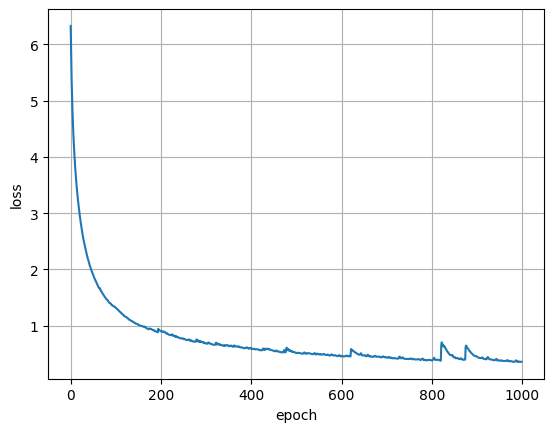

In [277]:
print(f'min loss: {min(losses)}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);

max metric: 9.148143768310547


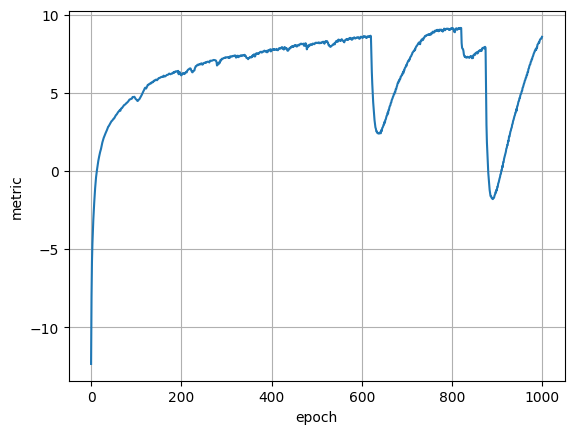

In [278]:
print(f'max metric: {max(metrics)}')

plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

In [271]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

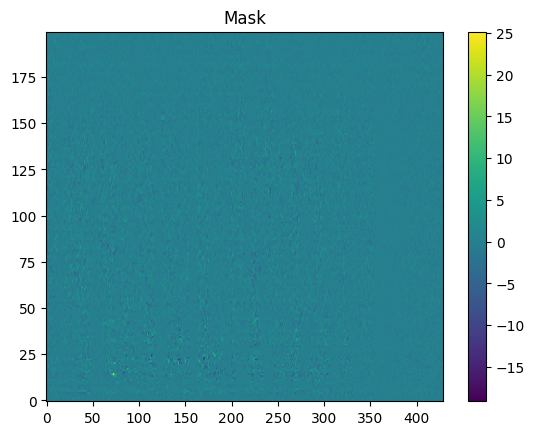

In [272]:
plot_mask(mask.detach()[0][0])

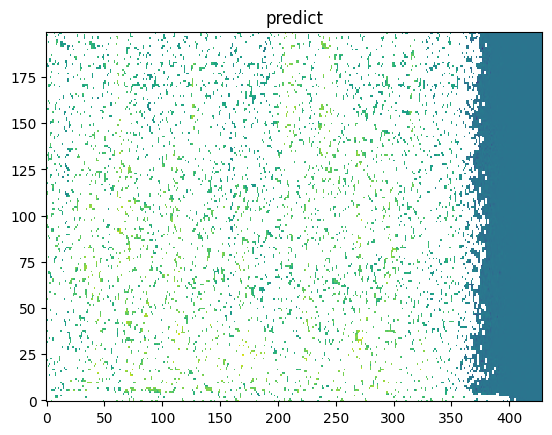

In [273]:
plt.title('predict')
plt.imshow(torch.log(mag_predict+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto");

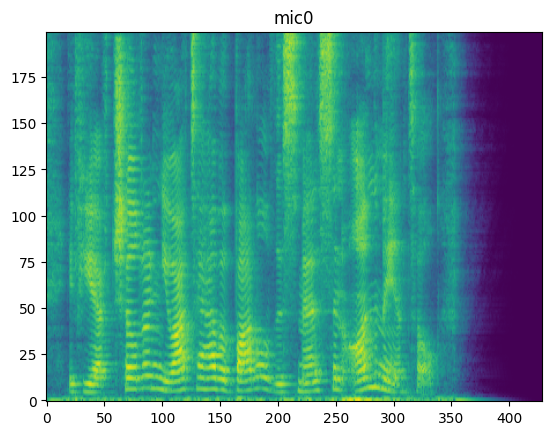

In [274]:
plt.title('mic0')
plt.imshow(torch.log(mag+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

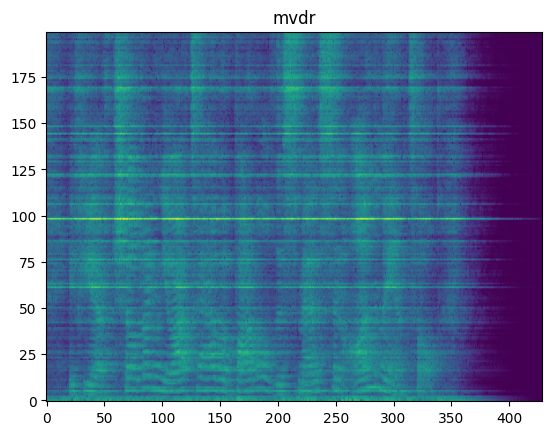

In [275]:
plt.title('mvdr')
plt.imshow(torch.log(mvdr(spec_sample, mask[0]).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

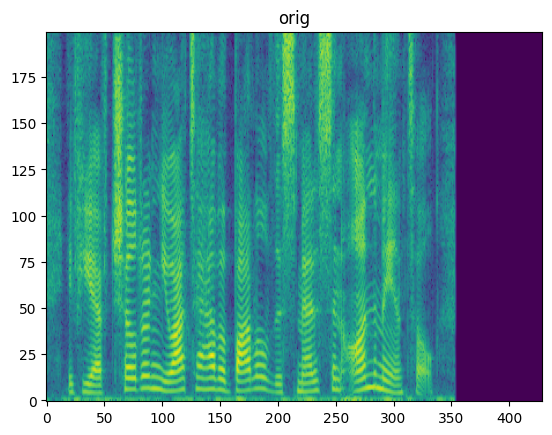

In [276]:
plt.title('orig')
plt.imshow(torch.log(stft.stft(train_target).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");